# MBA em Ciência de Dados - TCC
# Predição da Radiação Solar para Produção de Hidrogênio Verde: Análise comparativa de métodos de Aprendizado de Máquina

## Modelagem e Predição
**Material Produzido por:** Mateus Vasconcelos Albuquerque

**Cemeai - ICMC/USP São Carlos**


---------------------------------------------------------------------------------------------------------





## **CRISP-DS**

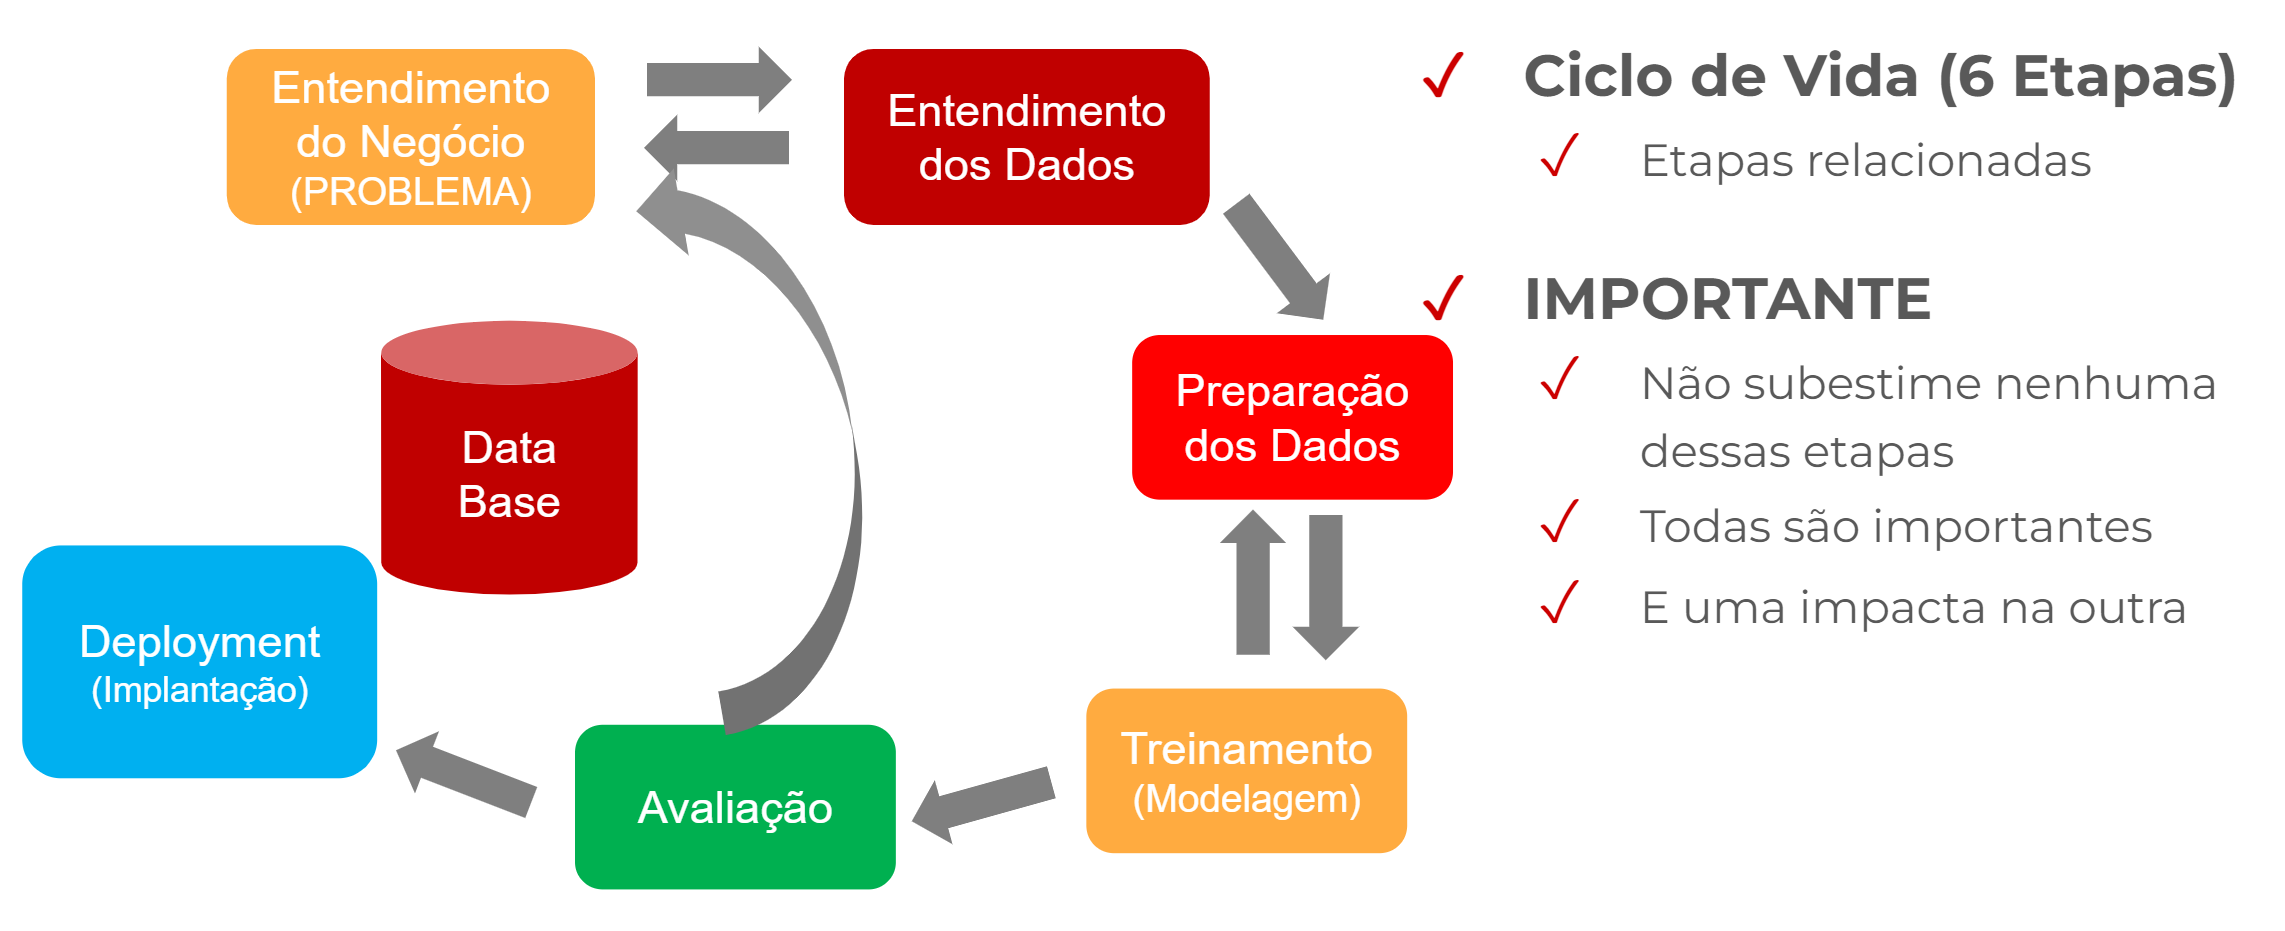

In [1]:
from google.colab import drive
import os

# Monta o Google Drive
drive.mount('/content/drive')

# Define o caminho da pasta 'Projetos'
projetos_path = '/content/drive/My Drive/MBA/TCC/Projeto'

# Define o diretório de trabalho para a pasta 'Projetos'
if os.path.exists(projetos_path):
    os.chdir(projetos_path)
    print(f"Diretório alterado para: {projetos_path}")
else:
    print(f"A pasta 'Projetos' não foi encontrada em: {projetos_path}")

Mounted at /content/drive
Diretório alterado para: /content/drive/My Drive/MBA/TCC/Projeto


## **3. Preparação dos Dados**

### 3.1. Import dos dados pré-processados

In [2]:
import pandas as pd
from pandas.plotting import lag_plot
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import yaml
import os

In [3]:
# Leitura do arquivo de configuração

# folder para carregar os config files
CONFIG_PATH = "config/"

# Função para carregar os dados
def load_config(config_name):
    with open(os.path.join(CONFIG_PATH, config_name)) as file:
        config = yaml.safe_load(file)

    return config

In [4]:
config = load_config("data_preprocessing_config_sobral.yaml")

# mostrar todas as colunas
pd.set_option("display.max_columns", None)

In [5]:
# Leitura dos dados a partir do CSV
codigo_wmo = config["input_data_parameters"]["codigo_wmo"]
estacao = config["input_data_parameters"]["estacao"]

input_dir = config["output_directory_preprocessing"]

filepath = f"{input_dir}/preprocessed_data_{codigo_wmo}_{estacao}.csv"

data = pd.read_csv(
    filepath,
    index_col=0,
)

# # remove last 5 columns
# data = data.iloc[:, :-5]

### 3.2. Scaling dos dados

In [6]:
features_target = ["precipitacao_total_horario", "pressao_atmosferica_nivel_estacao_horaria", "temperatura_ar_bulbo_seco_horaria", "umidade_relativa_ar_horaria", "vento_direcao_horaria", "vento_rajada_maxima", "vento_velocidade_horaria", "radiacao_global"]
data = data[features_target]

# Separar variável target e features
target = 'radiacao_global'
X = data.drop(columns=[target])
y = data[target]

In [7]:
from sklearn.preprocessing import MinMaxScaler
# Escalar os dados
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))

### 3.3. Preparação dos dados para LSTM

LSTMs esperam os dados no formato de 3 dimensões: (amostras, timesteps, features).

In [8]:
# Definição do número de timesteps (quantidade de passos anteriores usados para prever)
timesteps = 24  # 24 horas anteriores

# Criar sequências para treino
X_lstm, y_lstm = [], []

for i in range(timesteps, len(X_scaled)):
    X_lstm.append(X_scaled[i-timesteps:i])
    y_lstm.append(y_scaled[i])

X_lstm, y_lstm = np.array(X_lstm), np.array(y_lstm)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_lstm, y_lstm, test_size=0.3, shuffle=False)

### 3.4. Modelagem - LSTM simples

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 32s 29ms/step - loss: 0.0228 - val_loss: 0.0088
Epoch 2/50
959/959 ━━━━━━━━━━━━━━━━━━━━ 46s 35ms/step - loss: 0.0091 - val_loss: 0.0071
Epoch 3/50
957/959 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0076

KeyboardInterrupt: 

### 3.5 Predições e Avaliação - LSTM simples

In [ ]:
y_pred = model.predict(X_test)

# Inverter a escala para os valores originais
y_pred_original = scaler_y.inverse_transform(y_pred)
y_test_original = scaler_y.inverse_transform(y_test)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
mape = mean_absolute_percentage_error(y_test_original, y_pred_original) * 100

print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"MAPE: {mape}")

In [ ]:
# Selecionando os últimos 7 * 24 valores para visualização
last_values = 7 * 24
Y_ts_last = y_test_original[-last_values:]
preds_lstm_last = y_pred_original[-last_values:]

# Plotando os últimos valores
plt.figure(figsize=(14, 7))

# Comparando a primeira coluna (ou ajusta conforme a quantidade de targets)
plt.plot(Y_ts_last, label='Valores Reais')
plt.plot(preds_lstm_last, label='Previsões', linestyle='--')

# plt.title('Predição vs Valores Reais (Últimos 7 dias)')
plt.xlabel('Data')
plt.ylabel('Radiação')
plt.legend()
plt.show()

### 3.6. Random Search para Tuning de Hiperparâmetros

In [11]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Função para criar o modelo
def lstm_model(neurons=50, layers=1, dropout=0.2, learning_rate=0.001):
    model = Sequential()
    for i in range(layers):
        return_sequences = i < layers - 1  # Retorna sequências até a penúltima camada
        model.add(LSTM(neurons, return_sequences=return_sequences, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(dropout))
    model.add(Dense(1))  # Camada de saída
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model

In [ ]:
# !pip install --upgrade scikit-learn scikeras tensorflow

In [ ]:
# !pip uninstall -y scikit-learn
# !pip install scikit-learn==1.3.1

In [ ]:
# !pip install scikeras

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import TimeSeriesSplit

# # Wrapping o modelo Keras para Scikit-learn
# model_search = KerasRegressor(build_fn=lstm_model, verbose=2)

# Wrapping do modelo com SciKeras
regressor = KerasRegressor(
    model=lstm_model,
    verbose=2
)

# Hiperparâmetros para busca
param_distribs = {
    'model__neurons': [32, 64, 128, 256, 512],
    'model__layers': [1, 2],
    'model__dropout': [0.1, 0.2, 0.3, 0.5],
    'batch_size': [16, 32, 64],
    'model__learning_rate': [1e-4, 1e-3, 1e-2],
    'epochs': [50, 100, 200]
}

# Randomized Search com validação cruzada
# Usando TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=3)  # Define o número de divisões

random_search = RandomizedSearchCV(estimator=regressor, param_distributions=param_distribs,
                                   n_iter=20, scoring='neg_mean_squared_error', cv=tscv, verbose=2)

# Executar busca de hiperparâmetros
random_search.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros
print("Melhores hiperparâmetros:", random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
240/240 - 9s - 36ms/step - loss: 0.0296
Epoch 2/100
240/240 - 2s - 6ms/step - loss: 0.0138
Epoch 3/100
240/240 - 3s - 10ms/step - loss: 0.0124
Epoch 4/100
240/240 - 3s - 11ms/step - loss: 0.0112
Epoch 5/100
240/240 - 3s - 12ms/step - loss: 0.0113
Epoch 6/100
240/240 - 3s - 11ms/step - loss: 0.0105
Epoch 7/100
240/240 - 2s - 7ms/step - loss: 0.0102
Epoch 8/100
240/240 - 2s - 6ms/step - loss: 0.0099
Epoch 9/100
240/240 - 2s - 6ms/step - loss: 0.0100
Epoch 10/100
240/240 - 3s - 11ms/step - loss: 0.0093
Epoch 11/100
240/240 - 3s - 11ms/step - loss: 0.0093
Epoch 12/100
240/240 - 3s - 13ms/step - loss: 0.0089
Epoch 13/100
240/240 - 2s - 7ms/step - loss: 0.0087
Epoch 14/100
240/240 - 2s - 6ms/step - loss: 0.0083
Epoch 15/100
240/240 - 1s - 6ms/step - loss: 0.0082
Epoch 16/100
240/240 - 3s - 11ms/step - loss: 0.0082
Epoch 17/100
240/240 - 2s - 6ms/step - loss: 0.0077
Epoch 18/100
240/240 - 1s - 6ms/step - loss: 0.0077
Epoch 19/100
240/240 - 3s - 13ms/step - loss: 0.0074
Epoch 20/10

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


480/480 - 5s - 11ms/step - loss: 0.0233
Epoch 2/100
480/480 - 6s - 12ms/step - loss: 0.0126
Epoch 3/100
480/480 - 3s - 6ms/step - loss: 0.0115
Epoch 4/100
480/480 - 5s - 11ms/step - loss: 0.0105
Epoch 5/100
480/480 - 5s - 11ms/step - loss: 0.0096
Epoch 6/100
480/480 - 5s - 10ms/step - loss: 0.0090
Epoch 7/100
480/480 - 6s - 13ms/step - loss: 0.0087
Epoch 8/100
480/480 - 4s - 8ms/step - loss: 0.0083
Epoch 9/100
480/480 - 5s - 11ms/step - loss: 0.0080
Epoch 10/100
480/480 - 6s - 12ms/step - loss: 0.0077
Epoch 11/100
480/480 - 4s - 9ms/step - loss: 0.0077
Epoch 12/100
480/480 - 5s - 11ms/step - loss: 0.0074
Epoch 13/100
480/480 - 5s - 10ms/step - loss: 0.0072
Epoch 14/100
480/480 - 5s - 11ms/step - loss: 0.0072
Epoch 15/100
480/480 - 6s - 13ms/step - loss: 0.0070
Epoch 16/100
480/480 - 4s - 8ms/step - loss: 0.0068
Epoch 17/100
480/480 - 3s - 6ms/step - loss: 0.0068
Epoch 18/100
480/480 - 6s - 12ms/step - loss: 0.0066
Epoch 19/100
480/480 - 3s - 7ms/step - loss: 0.0067
Epoch 20/100
480/480

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


719/719 - 7s - 9ms/step - loss: 0.0208
Epoch 2/100
719/719 - 5s - 7ms/step - loss: 0.0127
Epoch 3/100
719/719 - 5s - 7ms/step - loss: 0.0115
Epoch 4/100
719/719 - 5s - 7ms/step - loss: 0.0104
Epoch 5/100
719/719 - 6s - 9ms/step - loss: 0.0096
Epoch 6/100
719/719 - 4s - 6ms/step - loss: 0.0091
Epoch 7/100
719/719 - 5s - 6ms/step - loss: 0.0087
Epoch 8/100
719/719 - 6s - 9ms/step - loss: 0.0085
Epoch 9/100
719/719 - 10s - 13ms/step - loss: 0.0082
Epoch 10/100
719/719 - 5s - 7ms/step - loss: 0.0081
Epoch 11/100
719/719 - 10s - 15ms/step - loss: 0.0080
Epoch 12/100
719/719 - 9s - 13ms/step - loss: 0.0078
Epoch 13/100
719/719 - 6s - 8ms/step - loss: 0.0076
Epoch 14/100
719/719 - 9s - 13ms/step - loss: 0.0076
Epoch 15/100
719/719 - 6s - 8ms/step - loss: 0.0075
Epoch 16/100
719/719 - 4s - 6ms/step - loss: 0.0075
Epoch 17/100
719/719 - 5s - 7ms/step - loss: 0.0072
Epoch 18/100
719/719 - 5s - 7ms/step - loss: 0.0071
Epoch 19/100
719/719 - 4s - 6ms/step - loss: 0.0071
Epoch 20/100
719/719 - 5s -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


480/480 - 6s - 13ms/step - loss: 0.0297
Epoch 2/50
480/480 - 3s - 6ms/step - loss: 0.0143
Epoch 3/50
480/480 - 5s - 11ms/step - loss: 0.0126
Epoch 4/50
480/480 - 6s - 13ms/step - loss: 0.0121
Epoch 5/50
480/480 - 3s - 6ms/step - loss: 0.0113
Epoch 6/50
480/480 - 5s - 11ms/step - loss: 0.0110
Epoch 7/50
480/480 - 3s - 7ms/step - loss: 0.0105
Epoch 8/50
480/480 - 4s - 9ms/step - loss: 0.0103
Epoch 9/50
480/480 - 5s - 11ms/step - loss: 0.0101
Epoch 10/50
480/480 - 6s - 12ms/step - loss: 0.0095
Epoch 11/50
480/480 - 4s - 9ms/step - loss: 0.0094
Epoch 12/50
480/480 - 5s - 11ms/step - loss: 0.0091
Epoch 13/50
480/480 - 5s - 10ms/step - loss: 0.0091
Epoch 14/50
480/480 - 3s - 6ms/step - loss: 0.0085
Epoch 15/50
480/480 - 3s - 6ms/step - loss: 0.0086
Epoch 16/50
480/480 - 3s - 7ms/step - loss: 0.0084
Epoch 17/50
480/480 - 5s - 10ms/step - loss: 0.0082
Epoch 18/50
480/480 - 5s - 11ms/step - loss: 0.0079
Epoch 19/50
480/480 - 6s - 13ms/step - loss: 0.0077
Epoch 20/50
480/480 - 3s - 6ms/step - lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


959/959 - 8s - 8ms/step - loss: 0.0224
Epoch 2/50
959/959 - 6s - 6ms/step - loss: 0.0128
Epoch 3/50
959/959 - 5s - 6ms/step - loss: 0.0116
Epoch 4/50
959/959 - 10s - 11ms/step - loss: 0.0106
Epoch 5/50
959/959 - 10s - 11ms/step - loss: 0.0100
Epoch 6/50
959/959 - 12s - 12ms/step - loss: 0.0092
Epoch 7/50
959/959 - 5s - 6ms/step - loss: 0.0087
Epoch 8/50
959/959 - 10s - 11ms/step - loss: 0.0084
Epoch 9/50
959/959 - 11s - 12ms/step - loss: 0.0079
Epoch 10/50
959/959 - 5s - 5ms/step - loss: 0.0077
Epoch 11/50
959/959 - 10s - 11ms/step - loss: 0.0075
Epoch 12/50
959/959 - 11s - 11ms/step - loss: 0.0074
Epoch 13/50
959/959 - 11s - 12ms/step - loss: 0.0072
Epoch 14/50
959/959 - 9s - 9ms/step - loss: 0.0072
Epoch 15/50
959/959 - 10s - 11ms/step - loss: 0.0070
Epoch 16/50
959/959 - 10s - 11ms/step - loss: 0.0069
Epoch 17/50
959/959 - 6s - 6ms/step - loss: 0.0068
Epoch 18/50
959/959 - 10s - 10ms/step - loss: 0.0068
Epoch 19/50
959/959 - 10s - 11ms/step - loss: 0.0066
Epoch 20/50
959/959 - 11s -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1438/1438 - 11s - 7ms/step - loss: 0.0209
Epoch 2/50
1438/1438 - 10s - 7ms/step - loss: 0.0129
Epoch 3/50
1438/1438 - 11s - 8ms/step - loss: 0.0115
Epoch 4/50
1438/1438 - 9s - 6ms/step - loss: 0.0106
Epoch 5/50
1438/1438 - 9s - 6ms/step - loss: 0.0097
Epoch 6/50
1438/1438 - 9s - 6ms/step - loss: 0.0092
Epoch 7/50
1438/1438 - 10s - 7ms/step - loss: 0.0089
Epoch 8/50
1438/1438 - 9s - 6ms/step - loss: 0.0085
Epoch 9/50
1438/1438 - 10s - 7ms/step - loss: 0.0083
Epoch 10/50
1438/1438 - 9s - 6ms/step - loss: 0.0081
Epoch 11/50
1438/1438 - 10s - 7ms/step - loss: 0.0079
Epoch 12/50
1438/1438 - 10s - 7ms/step - loss: 0.0078
Epoch 13/50
1438/1438 - 11s - 8ms/step - loss: 0.0077
Epoch 14/50
1438/1438 - 11s - 8ms/step - loss: 0.0076
Epoch 15/50
1438/1438 - 8s - 6ms/step - loss: 0.0075
Epoch 16/50
1438/1438 - 9s - 6ms/step - loss: 0.0074
Epoch 17/50
1438/1438 - 11s - 8ms/step - loss: 0.0073
Epoch 18/50
1438/1438 - 9s - 6ms/step - loss: 0.0072
Epoch 19/50
1438/1438 - 10s - 7ms/step - loss: 0.0071
Ep

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


240/240 - 2s - 10ms/step - loss: 0.0387
Epoch 2/50
240/240 - 1s - 5ms/step - loss: 0.0166
Epoch 3/50
240/240 - 1s - 5ms/step - loss: 0.0143
Epoch 4/50
240/240 - 1s - 4ms/step - loss: 0.0130
Epoch 5/50
240/240 - 1s - 4ms/step - loss: 0.0123
Epoch 6/50
240/240 - 2s - 7ms/step - loss: 0.0117
Epoch 7/50
240/240 - 3s - 11ms/step - loss: 0.0113
Epoch 8/50
240/240 - 1s - 4ms/step - loss: 0.0113
Epoch 9/50
240/240 - 1s - 4ms/step - loss: 0.0105
Epoch 10/50
240/240 - 1s - 4ms/step - loss: 0.0105
Epoch 11/50
240/240 - 1s - 5ms/step - loss: 0.0100
Epoch 12/50
240/240 - 1s - 5ms/step - loss: 0.0100
Epoch 13/50
240/240 - 1s - 5ms/step - loss: 0.0096
Epoch 14/50
240/240 - 1s - 4ms/step - loss: 0.0095
Epoch 15/50
240/240 - 1s - 4ms/step - loss: 0.0094
Epoch 16/50
240/240 - 1s - 4ms/step - loss: 0.0092
Epoch 17/50
240/240 - 2s - 7ms/step - loss: 0.0090
Epoch 18/50
240/240 - 2s - 9ms/step - loss: 0.0087
Epoch 19/50
240/240 - 1s - 5ms/step - loss: 0.0084
Epoch 20/50
240/240 - 1s - 4ms/step - loss: 0.008

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


480/480 - 3s - 7ms/step - loss: 0.0350
Epoch 2/50
480/480 - 2s - 4ms/step - loss: 0.0152
Epoch 3/50
480/480 - 3s - 7ms/step - loss: 0.0134
Epoch 4/50
480/480 - 2s - 5ms/step - loss: 0.0126
Epoch 5/50
480/480 - 2s - 4ms/step - loss: 0.0116
Epoch 6/50
480/480 - 3s - 5ms/step - loss: 0.0109
Epoch 7/50
480/480 - 3s - 5ms/step - loss: 0.0105
Epoch 8/50
480/480 - 3s - 6ms/step - loss: 0.0099
Epoch 9/50
480/480 - 3s - 6ms/step - loss: 0.0094
Epoch 10/50
480/480 - 2s - 4ms/step - loss: 0.0092
Epoch 11/50
480/480 - 2s - 4ms/step - loss: 0.0089
Epoch 12/50
480/480 - 2s - 4ms/step - loss: 0.0087
Epoch 13/50
480/480 - 3s - 5ms/step - loss: 0.0084
Epoch 14/50
480/480 - 3s - 6ms/step - loss: 0.0082
Epoch 15/50
480/480 - 3s - 6ms/step - loss: 0.0081
Epoch 16/50
480/480 - 2s - 4ms/step - loss: 0.0079
Epoch 17/50
480/480 - 2s - 4ms/step - loss: 0.0077
Epoch 18/50
480/480 - 2s - 4ms/step - loss: 0.0077
Epoch 19/50
480/480 - 3s - 5ms/step - loss: 0.0074
Epoch 20/50
480/480 - 2s - 4ms/step - loss: 0.0073


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


719/719 - 4s - 6ms/step - loss: 0.0252
Epoch 2/50
719/719 - 3s - 4ms/step - loss: 0.0140
Epoch 3/50
719/719 - 6s - 8ms/step - loss: 0.0127
Epoch 4/50
719/719 - 3s - 4ms/step - loss: 0.0117
Epoch 5/50
719/719 - 3s - 4ms/step - loss: 0.0112
Epoch 6/50
719/719 - 3s - 5ms/step - loss: 0.0105
Epoch 7/50
719/719 - 4s - 5ms/step - loss: 0.0099
Epoch 8/50
719/719 - 3s - 4ms/step - loss: 0.0096
Epoch 9/50
719/719 - 3s - 4ms/step - loss: 0.0092
Epoch 10/50
719/719 - 6s - 9ms/step - loss: 0.0090
Epoch 11/50
719/719 - 3s - 4ms/step - loss: 0.0088
Epoch 12/50
719/719 - 3s - 4ms/step - loss: 0.0086
Epoch 13/50
719/719 - 3s - 4ms/step - loss: 0.0084
Epoch 14/50
719/719 - 6s - 8ms/step - loss: 0.0082
Epoch 15/50
719/719 - 3s - 4ms/step - loss: 0.0080
Epoch 16/50
719/719 - 3s - 4ms/step - loss: 0.0079
Epoch 17/50
719/719 - 3s - 4ms/step - loss: 0.0078
Epoch 18/50
719/719 - 5s - 7ms/step - loss: 0.0077
Epoch 19/50
719/719 - 5s - 7ms/step - loss: 0.0076
Epoch 20/50
719/719 - 3s - 4ms/step - loss: 0.0076


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 - 2s - 14ms/step - loss: 0.0229
Epoch 2/50
120/120 - 1s - 5ms/step - loss: 0.0101
Epoch 3/50
120/120 - 1s - 5ms/step - loss: 0.0082
Epoch 4/50
120/120 - 0s - 4ms/step - loss: 0.0079
Epoch 5/50
120/120 - 0s - 4ms/step - loss: 0.0069
Epoch 6/50
120/120 - 1s - 5ms/step - loss: 0.0074
Epoch 7/50
120/120 - 0s - 4ms/step - loss: 0.0068
Epoch 8/50
120/120 - 0s - 4ms/step - loss: 0.0067
Epoch 9/50
120/120 - 0s - 4ms/step - loss: 0.0071
Epoch 10/50
120/120 - 0s - 4ms/step - loss: 0.0066
Epoch 11/50
120/120 - 1s - 5ms/step - loss: 0.0063
Epoch 12/50
120/120 - 1s - 5ms/step - loss: 0.0065
Epoch 13/50
120/120 - 1s - 6ms/step - loss: 0.0062
Epoch 14/50
120/120 - 1s - 10ms/step - loss: 0.0061
Epoch 15/50
120/120 - 1s - 6ms/step - loss: 0.0060
Epoch 16/50
120/120 - 1s - 5ms/step - loss: 0.0060
Epoch 17/50
120/120 - 0s - 4ms/step - loss: 0.0062
Epoch 18/50
120/120 - 0s - 4ms/step - loss: 0.0061
Epoch 19/50
120/120 - 0s - 4ms/step - loss: 0.0057
Epoch 20/50
120/120 - 0s - 4ms/step - loss: 0.005

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


240/240 - 2s - 9ms/step - loss: 0.0200
Epoch 2/50
240/240 - 2s - 7ms/step - loss: 0.0086
Epoch 3/50
240/240 - 1s - 6ms/step - loss: 0.0074
Epoch 4/50
240/240 - 1s - 6ms/step - loss: 0.0069
Epoch 5/50
240/240 - 1s - 4ms/step - loss: 0.0066
Epoch 6/50
240/240 - 1s - 5ms/step - loss: 0.0066
Epoch 7/50
240/240 - 1s - 4ms/step - loss: 0.0063
Epoch 8/50
240/240 - 1s - 4ms/step - loss: 0.0064
Epoch 9/50
240/240 - 1s - 4ms/step - loss: 0.0061
Epoch 10/50
240/240 - 1s - 4ms/step - loss: 0.0060
Epoch 11/50
240/240 - 1s - 4ms/step - loss: 0.0061
Epoch 12/50
240/240 - 1s - 4ms/step - loss: 0.0060
Epoch 13/50
240/240 - 1s - 4ms/step - loss: 0.0059
Epoch 14/50
240/240 - 1s - 5ms/step - loss: 0.0059
Epoch 15/50
240/240 - 2s - 7ms/step - loss: 0.0058
Epoch 16/50
240/240 - 2s - 9ms/step - loss: 0.0058
Epoch 17/50
240/240 - 1s - 4ms/step - loss: 0.0057
Epoch 18/50
240/240 - 1s - 5ms/step - loss: 0.0058
Epoch 19/50
240/240 - 1s - 5ms/step - loss: 0.0057
Epoch 20/50
240/240 - 1s - 5ms/step - loss: 0.0056


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


360/360 - 3s - 7ms/step - loss: 0.0139
Epoch 2/50
360/360 - 3s - 9ms/step - loss: 0.0089
Epoch 3/50
360/360 - 3s - 7ms/step - loss: 0.0080
Epoch 4/50
360/360 - 1s - 4ms/step - loss: 0.0077
Epoch 5/50
360/360 - 1s - 4ms/step - loss: 0.0073
Epoch 6/50
360/360 - 3s - 7ms/step - loss: 0.0071
Epoch 7/50
360/360 - 1s - 4ms/step - loss: 0.0070
Epoch 8/50
360/360 - 3s - 7ms/step - loss: 0.0067
Epoch 9/50
360/360 - 3s - 9ms/step - loss: 0.0066
Epoch 10/50
360/360 - 2s - 4ms/step - loss: 0.0063
Epoch 11/50
360/360 - 2s - 7ms/step - loss: 0.0064
Epoch 12/50
360/360 - 3s - 7ms/step - loss: 0.0065
Epoch 13/50
360/360 - 1s - 4ms/step - loss: 0.0063
Epoch 14/50
360/360 - 1s - 4ms/step - loss: 0.0062
Epoch 15/50
360/360 - 3s - 9ms/step - loss: 0.0062
Epoch 16/50
360/360 - 2s - 6ms/step - loss: 0.0061
Epoch 17/50
360/360 - 2s - 5ms/step - loss: 0.0061
Epoch 18/50
360/360 - 1s - 4ms/step - loss: 0.0060
Epoch 19/50
360/360 - 1s - 4ms/step - loss: 0.0060
Epoch 20/50
360/360 - 3s - 7ms/step - loss: 0.0060


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 - 2s - 16ms/step - loss: 0.0246
Epoch 2/100
120/120 - 1s - 4ms/step - loss: 0.0125
Epoch 3/100
120/120 - 1s - 5ms/step - loss: 0.0112
Epoch 4/100
120/120 - 1s - 4ms/step - loss: 0.0101
Epoch 5/100
120/120 - 1s - 5ms/step - loss: 0.0092
Epoch 6/100
120/120 - 1s - 4ms/step - loss: 0.0090
Epoch 7/100
120/120 - 1s - 4ms/step - loss: 0.0086
Epoch 8/100
120/120 - 1s - 5ms/step - loss: 0.0079
Epoch 9/100
120/120 - 1s - 4ms/step - loss: 0.0078
Epoch 10/100
120/120 - 1s - 5ms/step - loss: 0.0074
Epoch 11/100
120/120 - 1s - 4ms/step - loss: 0.0074
Epoch 12/100
120/120 - 1s - 4ms/step - loss: 0.0070
Epoch 13/100
120/120 - 1s - 5ms/step - loss: 0.0069
Epoch 14/100
120/120 - 1s - 4ms/step - loss: 0.0067
Epoch 15/100
120/120 - 1s - 6ms/step - loss: 0.0068
Epoch 16/100
120/120 - 1s - 6ms/step - loss: 0.0066
Epoch 17/100
120/120 - 1s - 11ms/step - loss: 0.0066
Epoch 18/100
120/120 - 1s - 6ms/step - loss: 0.0065
Epoch 19/100
120/120 - 1s - 6ms/step - loss: 0.0065
Epoch 20/100
120/120 - 1s - 4ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


240/240 - 2s - 10ms/step - loss: 0.0185
Epoch 2/100
240/240 - 1s - 5ms/step - loss: 0.0108
Epoch 3/100
240/240 - 1s - 5ms/step - loss: 0.0095
Epoch 4/100
240/240 - 1s - 4ms/step - loss: 0.0088
Epoch 5/100
240/240 - 1s - 5ms/step - loss: 0.0082
Epoch 6/100
240/240 - 1s - 5ms/step - loss: 0.0076
Epoch 7/100
240/240 - 1s - 4ms/step - loss: 0.0073
Epoch 8/100
240/240 - 2s - 7ms/step - loss: 0.0071
Epoch 9/100
240/240 - 2s - 10ms/step - loss: 0.0069
Epoch 10/100
240/240 - 1s - 4ms/step - loss: 0.0067
Epoch 11/100
240/240 - 1s - 4ms/step - loss: 0.0067
Epoch 12/100
240/240 - 1s - 4ms/step - loss: 0.0067
Epoch 13/100
240/240 - 1s - 5ms/step - loss: 0.0065
Epoch 14/100
240/240 - 1s - 5ms/step - loss: 0.0065
Epoch 15/100
240/240 - 1s - 5ms/step - loss: 0.0064
Epoch 16/100
240/240 - 1s - 5ms/step - loss: 0.0063
Epoch 17/100
240/240 - 1s - 6ms/step - loss: 0.0063
Epoch 18/100
240/240 - 1s - 6ms/step - loss: 0.0061
Epoch 19/100
240/240 - 1s - 6ms/step - loss: 0.0061
Epoch 20/100
240/240 - 1s - 5ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


360/360 - 3s - 8ms/step - loss: 0.0175
Epoch 2/100
360/360 - 2s - 4ms/step - loss: 0.0106
Epoch 3/100
360/360 - 1s - 4ms/step - loss: 0.0093
Epoch 4/100
360/360 - 3s - 7ms/step - loss: 0.0085
Epoch 5/100
360/360 - 3s - 8ms/step - loss: 0.0082
Epoch 6/100
360/360 - 3s - 7ms/step - loss: 0.0078
Epoch 7/100
360/360 - 2s - 6ms/step - loss: 0.0076
Epoch 8/100
360/360 - 1s - 4ms/step - loss: 0.0074
Epoch 9/100
360/360 - 3s - 7ms/step - loss: 0.0072
Epoch 10/100
360/360 - 3s - 7ms/step - loss: 0.0071
Epoch 11/100
360/360 - 3s - 9ms/step - loss: 0.0069
Epoch 12/100
360/360 - 2s - 6ms/step - loss: 0.0068
Epoch 13/100
360/360 - 2s - 7ms/step - loss: 0.0067
Epoch 14/100
360/360 - 3s - 7ms/step - loss: 0.0065
Epoch 15/100
360/360 - 3s - 7ms/step - loss: 0.0065
Epoch 16/100
360/360 - 3s - 9ms/step - loss: 0.0063
Epoch 17/100
360/360 - 2s - 6ms/step - loss: 0.0063
Epoch 18/100
360/360 - 2s - 6ms/step - loss: 0.0062
Epoch 19/100
360/360 - 1s - 4ms/step - loss: 0.0062
Epoch 20/100
360/360 - 3s - 7ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


240/240 - 4s - 16ms/step - loss: 0.0250
Epoch 2/50
240/240 - 3s - 11ms/step - loss: 0.0131
Epoch 3/50
240/240 - 2s - 7ms/step - loss: 0.0117
Epoch 4/50
240/240 - 3s - 13ms/step - loss: 0.0106
Epoch 5/50
240/240 - 1s - 6ms/step - loss: 0.0099
Epoch 6/50
240/240 - 1s - 6ms/step - loss: 0.0088
Epoch 7/50
240/240 - 3s - 11ms/step - loss: 0.0086
Epoch 8/50
240/240 - 3s - 11ms/step - loss: 0.0081
Epoch 9/50
240/240 - 1s - 6ms/step - loss: 0.0077
Epoch 10/50
240/240 - 2s - 7ms/step - loss: 0.0079
Epoch 11/50
240/240 - 2s - 8ms/step - loss: 0.0079
Epoch 12/50
240/240 - 2s - 8ms/step - loss: 0.0072
Epoch 13/50
240/240 - 2s - 9ms/step - loss: 0.0074
Epoch 14/50
240/240 - 3s - 11ms/step - loss: 0.0075
Epoch 15/50
240/240 - 1s - 6ms/step - loss: 0.0071
Epoch 16/50
240/240 - 3s - 11ms/step - loss: 0.0072
Epoch 17/50
240/240 - 3s - 13ms/step - loss: 0.0070
Epoch 18/50
240/240 - 2s - 8ms/step - loss: 0.0068
Epoch 19/50
240/240 - 1s - 6ms/step - loss: 0.0068
Epoch 20/50
240/240 - 1s - 6ms/step - loss:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


480/480 - 5s - 10ms/step - loss: 0.0226
Epoch 2/50
480/480 - 3s - 6ms/step - loss: 0.0121
Epoch 3/50
480/480 - 6s - 12ms/step - loss: 0.0101
Epoch 4/50
480/480 - 4s - 9ms/step - loss: 0.0088
Epoch 5/50
480/480 - 5s - 11ms/step - loss: 0.0082
Epoch 6/50
480/480 - 6s - 12ms/step - loss: 0.0080
Epoch 7/50
480/480 - 4s - 9ms/step - loss: 0.0077
Epoch 8/50
480/480 - 3s - 5ms/step - loss: 0.0075
Epoch 9/50
480/480 - 3s - 6ms/step - loss: 0.0074
Epoch 10/50
480/480 - 4s - 8ms/step - loss: 0.0073
Epoch 11/50
480/480 - 3s - 5ms/step - loss: 0.0072
Epoch 12/50
480/480 - 5s - 11ms/step - loss: 0.0069
Epoch 13/50
480/480 - 6s - 12ms/step - loss: 0.0069
Epoch 14/50
480/480 - 3s - 5ms/step - loss: 0.0068
Epoch 15/50
480/480 - 3s - 5ms/step - loss: 0.0068
Epoch 16/50
480/480 - 3s - 6ms/step - loss: 0.0066
Epoch 17/50
480/480 - 6s - 12ms/step - loss: 0.0065
Epoch 18/50
480/480 - 3s - 5ms/step - loss: 0.0065
Epoch 19/50
480/480 - 5s - 11ms/step - loss: 0.0064
Epoch 20/50
480/480 - 6s - 12ms/step - loss

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


719/719 - 7s - 10ms/step - loss: 0.0199
Epoch 2/50
719/719 - 5s - 7ms/step - loss: 0.0117
Epoch 3/50
719/719 - 5s - 7ms/step - loss: 0.0100
Epoch 4/50
719/719 - 9s - 12ms/step - loss: 0.0092
Epoch 5/50
719/719 - 5s - 7ms/step - loss: 0.0087
Epoch 6/50
719/719 - 9s - 12ms/step - loss: 0.0086
Epoch 7/50
719/719 - 5s - 7ms/step - loss: 0.0083
Epoch 8/50
719/719 - 9s - 12ms/step - loss: 0.0079
Epoch 9/50
719/719 - 6s - 9ms/step - loss: 0.0077
Epoch 10/50
719/719 - 9s - 13ms/step - loss: 0.0076
Epoch 11/50
719/719 - 5s - 7ms/step - loss: 0.0073
Epoch 12/50
719/719 - 4s - 5ms/step - loss: 0.0072
Epoch 13/50
719/719 - 5s - 6ms/step - loss: 0.0071
Epoch 14/50
719/719 - 5s - 7ms/step - loss: 0.0070
Epoch 15/50
719/719 - 4s - 6ms/step - loss: 0.0069
Epoch 16/50
719/719 - 6s - 8ms/step - loss: 0.0068
Epoch 17/50
719/719 - 4s - 6ms/step - loss: 0.0067
Epoch 18/50
719/719 - 5s - 7ms/step - loss: 0.0065
Epoch 19/50
719/719 - 5s - 7ms/step - loss: 0.0065
Epoch 20/50
719/719 - 4s - 6ms/step - loss: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 - 2s - 15ms/step - loss: 0.0842
Epoch 2/100
120/120 - 1s - 5ms/step - loss: 0.0559
Epoch 3/100
120/120 - 1s - 5ms/step - loss: 0.0407
Epoch 4/100
120/120 - 1s - 5ms/step - loss: 0.0285
Epoch 5/100
120/120 - 0s - 4ms/step - loss: 0.0221
Epoch 6/100
120/120 - 1s - 5ms/step - loss: 0.0192
Epoch 7/100
120/120 - 1s - 5ms/step - loss: 0.0173
Epoch 8/100
120/120 - 0s - 4ms/step - loss: 0.0158
Epoch 9/100
120/120 - 1s - 5ms/step - loss: 0.0150
Epoch 10/100
120/120 - 1s - 6ms/step - loss: 0.0141
Epoch 11/100
120/120 - 1s - 6ms/step - loss: 0.0136
Epoch 12/100
120/120 - 1s - 11ms/step - loss: 0.0135
Epoch 13/100
120/120 - 1s - 10ms/step - loss: 0.0129
Epoch 14/100
120/120 - 0s - 4ms/step - loss: 0.0128
Epoch 15/100
120/120 - 1s - 5ms/step - loss: 0.0124
Epoch 16/100
120/120 - 0s - 4ms/step - loss: 0.0124
Epoch 17/100
120/120 - 1s - 5ms/step - loss: 0.0120
Epoch 18/100
120/120 - 0s - 4ms/step - loss: 0.0120
Epoch 19/100
120/120 - 0s - 4ms/step - loss: 0.0119
Epoch 20/100
120/120 - 1s - 5m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


240/240 - 2s - 9ms/step - loss: 0.0542
Epoch 2/100
240/240 - 1s - 5ms/step - loss: 0.0219
Epoch 3/100
240/240 - 1s - 4ms/step - loss: 0.0173
Epoch 4/100
240/240 - 1s - 5ms/step - loss: 0.0152
Epoch 5/100
240/240 - 1s - 4ms/step - loss: 0.0139
Epoch 6/100
240/240 - 2s - 6ms/step - loss: 0.0132
Epoch 7/100
240/240 - 1s - 6ms/step - loss: 0.0125
Epoch 8/100
240/240 - 1s - 6ms/step - loss: 0.0118
Epoch 9/100
240/240 - 1s - 4ms/step - loss: 0.0117
Epoch 10/100
240/240 - 1s - 4ms/step - loss: 0.0114
Epoch 11/100
240/240 - 1s - 4ms/step - loss: 0.0109
Epoch 12/100
240/240 - 1s - 5ms/step - loss: 0.0110
Epoch 13/100
240/240 - 1s - 4ms/step - loss: 0.0107
Epoch 14/100
240/240 - 1s - 4ms/step - loss: 0.0104
Epoch 15/100
240/240 - 1s - 5ms/step - loss: 0.0103
Epoch 16/100
240/240 - 1s - 4ms/step - loss: 0.0101
Epoch 17/100
240/240 - 1s - 4ms/step - loss: 0.0100
Epoch 18/100
240/240 - 1s - 4ms/step - loss: 0.0097
Epoch 19/100
240/240 - 1s - 5ms/step - loss: 0.0097
Epoch 20/100
240/240 - 2s - 10ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


360/360 - 3s - 7ms/step - loss: 0.0512
Epoch 2/100
360/360 - 2s - 4ms/step - loss: 0.0213
Epoch 3/100
360/360 - 2s - 6ms/step - loss: 0.0171
Epoch 4/100
360/360 - 2s - 5ms/step - loss: 0.0153
Epoch 5/100
360/360 - 2s - 6ms/step - loss: 0.0142
Epoch 6/100
360/360 - 1s - 4ms/step - loss: 0.0134
Epoch 7/100
360/360 - 1s - 4ms/step - loss: 0.0128
Epoch 8/100
360/360 - 3s - 7ms/step - loss: 0.0125
Epoch 9/100
360/360 - 1s - 4ms/step - loss: 0.0123
Epoch 10/100
360/360 - 2s - 5ms/step - loss: 0.0118
Epoch 11/100
360/360 - 2s - 6ms/step - loss: 0.0115
Epoch 12/100
360/360 - 2s - 5ms/step - loss: 0.0113
Epoch 13/100
360/360 - 3s - 7ms/step - loss: 0.0110
Epoch 14/100
360/360 - 1s - 4ms/step - loss: 0.0108
Epoch 15/100
360/360 - 3s - 7ms/step - loss: 0.0107
Epoch 16/100
360/360 - 1s - 4ms/step - loss: 0.0106
Epoch 17/100
360/360 - 3s - 9ms/step - loss: 0.0104
Epoch 18/100
360/360 - 2s - 5ms/step - loss: 0.0103
Epoch 19/100
360/360 - 2s - 7ms/step - loss: 0.0101
Epoch 20/100
360/360 - 3s - 7ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


240/240 - 2s - 9ms/step - loss: 0.0170
Epoch 2/200
240/240 - 1s - 4ms/step - loss: 0.0101
Epoch 3/200
240/240 - 1s - 5ms/step - loss: 0.0089
Epoch 4/200
240/240 - 1s - 4ms/step - loss: 0.0083
Epoch 5/200
240/240 - 1s - 5ms/step - loss: 0.0074
Epoch 6/200
240/240 - 1s - 4ms/step - loss: 0.0074
Epoch 7/200
240/240 - 1s - 4ms/step - loss: 0.0070
Epoch 8/200
240/240 - 1s - 4ms/step - loss: 0.0068
Epoch 9/200
240/240 - 1s - 5ms/step - loss: 0.0066
Epoch 10/200
240/240 - 1s - 6ms/step - loss: 0.0063
Epoch 11/200
240/240 - 1s - 6ms/step - loss: 0.0062
Epoch 12/200
240/240 - 2s - 9ms/step - loss: 0.0060
Epoch 13/200
240/240 - 1s - 4ms/step - loss: 0.0060
Epoch 14/200
240/240 - 1s - 4ms/step - loss: 0.0058
Epoch 15/200
240/240 - 1s - 5ms/step - loss: 0.0057
Epoch 16/200
240/240 - 1s - 4ms/step - loss: 0.0056
Epoch 17/200
240/240 - 1s - 5ms/step - loss: 0.0057
Epoch 18/200
240/240 - 1s - 4ms/step - loss: 0.0057
Epoch 19/200
240/240 - 1s - 4ms/step - loss: 0.0056
Epoch 20/200
240/240 - 1s - 6ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


480/480 - 3s - 6ms/step - loss: 0.0142
Epoch 2/200
480/480 - 3s - 7ms/step - loss: 0.0091
Epoch 3/200
480/480 - 2s - 5ms/step - loss: 0.0079
Epoch 4/200
480/480 - 2s - 4ms/step - loss: 0.0072
Epoch 5/200
480/480 - 2s - 4ms/step - loss: 0.0067
Epoch 6/200
480/480 - 2s - 4ms/step - loss: 0.0064
Epoch 7/200
480/480 - 2s - 4ms/step - loss: 0.0062
Epoch 8/200
480/480 - 3s - 7ms/step - loss: 0.0060
Epoch 9/200
480/480 - 3s - 5ms/step - loss: 0.0059
Epoch 10/200
480/480 - 2s - 4ms/step - loss: 0.0058
Epoch 11/200
480/480 - 3s - 5ms/step - loss: 0.0058
Epoch 12/200
480/480 - 3s - 5ms/step - loss: 0.0057
Epoch 13/200
480/480 - 3s - 6ms/step - loss: 0.0056
Epoch 14/200
480/480 - 3s - 7ms/step - loss: 0.0055
Epoch 15/200
480/480 - 4s - 9ms/step - loss: 0.0054
Epoch 16/200
480/480 - 2s - 4ms/step - loss: 0.0056
Epoch 17/200
480/480 - 2s - 4ms/step - loss: 0.0054
Epoch 18/200
480/480 - 3s - 6ms/step - loss: 0.0054
Epoch 19/200
480/480 - 3s - 6ms/step - loss: 0.0053
Epoch 20/200
480/480 - 4s - 9ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


719/719 - 4s - 5ms/step - loss: 0.0128
Epoch 2/200
719/719 - 3s - 4ms/step - loss: 0.0088
Epoch 3/200
719/719 - 3s - 4ms/step - loss: 0.0079
Epoch 4/200
719/719 - 4s - 6ms/step - loss: 0.0074
Epoch 5/200
719/719 - 4s - 5ms/step - loss: 0.0071
Epoch 6/200
719/719 - 3s - 4ms/step - loss: 0.0068
Epoch 7/200
719/719 - 6s - 8ms/step - loss: 0.0065
Epoch 8/200
719/719 - 4s - 6ms/step - loss: 0.0063
Epoch 9/200
719/719 - 3s - 4ms/step - loss: 0.0061
Epoch 10/200
719/719 - 3s - 4ms/step - loss: 0.0060
Epoch 11/200
719/719 - 6s - 8ms/step - loss: 0.0060
Epoch 12/200
719/719 - 3s - 4ms/step - loss: 0.0058
Epoch 13/200
719/719 - 3s - 4ms/step - loss: 0.0058
Epoch 14/200
719/719 - 6s - 9ms/step - loss: 0.0057
Epoch 15/200
719/719 - 3s - 4ms/step - loss: 0.0056
Epoch 16/200
719/719 - 5s - 7ms/step - loss: 0.0056
Epoch 17/200
719/719 - 6s - 9ms/step - loss: 0.0056
Epoch 18/200
719/719 - 3s - 4ms/step - loss: 0.0056
Epoch 19/200
719/719 - 3s - 4ms/step - loss: 0.0054
Epoch 20/200
719/719 - 6s - 8ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
240/240 - 3s - 11ms/step - loss: 0.8579
Epoch 2/50
240/240 - 2s - 7ms/step - loss: 0.0194
Epoch 3/50
240/240 - 2s - 10ms/step - loss: 0.0138
Epoch 4/50
240/240 - 2s - 10ms/step - loss: 0.0117
Epoch 5/50
240/240 - 3s - 11ms/step - loss: 0.0104
Epoch 6/50
240/240 - 1s - 6ms/step - loss: 0.0097
Epoch 7/50
240/240 - 1s - 6ms/step - loss: 0.0090
Epoch 8/50
240/240 - 1s - 6ms/step - loss: 0.0091
Epoch 9/50
240/240 - 2s - 7ms/step - loss: 0.0085
Epoch 10/50
240/240 - 2s - 10ms/step - loss: 0.0085
Epoch 11/50
240/240 - 2s - 10ms/step - loss: 0.0086
Epoch 12/50
240/240 - 1s - 6ms/step - loss: 0.0077
Epoch 13/50
240/240 - 1s - 6ms/step - loss: 0.0079
Epoch 14/50
240/240 - 3s - 11ms/step - loss: 0.0075
Epoch 15/50
240/240 - 3s - 12ms/step - loss: 0.0075
Epoch 16/50
240/240 - 3s - 11ms/step - loss: 0.0075
Epoch 17/50
240/240 - 1s - 6ms/step - loss: 0.0073
Epoch 18/50
240/240 - 3s - 11ms/step - loss: 0.0077
Epoch 19/50
240/240 - 1s - 6ms/step - loss: 0.0069
Epoch 20/50
240/240 - 3s - 10m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
480/480 - 4s - 9ms/step - loss: 0.4644
Epoch 2/50
480/480 - 5s - 11ms/step - loss: 0.0366
Epoch 3/50
480/480 - 5s - 10ms/step - loss: 0.0199
Epoch 4/50
480/480 - 5s - 11ms/step - loss: 0.0139
Epoch 5/50
480/480 - 5s - 10ms/step - loss: 0.0134
Epoch 6/50
480/480 - 3s - 6ms/step - loss: 0.0130
Epoch 7/50
480/480 - 3s - 6ms/step - loss: 0.0110
Epoch 8/50
480/480 - 3s - 7ms/step - loss: 0.0102
Epoch 9/50
480/480 - 3s - 6ms/step - loss: 0.2197
Epoch 10/50
480/480 - 5s - 10ms/step - loss: 0.0473
Epoch 11/50
480/480 - 3s - 6ms/step - loss: 0.0314
Epoch 12/50
480/480 - 5s - 11ms/step - loss: 0.0296
Epoch 13/50
480/480 - 5s - 11ms/step - loss: 0.0224
Epoch 14/50
480/480 - 3s - 6ms/step - loss: 0.0193
Epoch 15/50
480/480 - 5s - 10ms/step - loss: 0.0207
Epoch 16/50
480/480 - 5s - 11ms/step - loss: 0.0182
Epoch 17/50
480/480 - 3s - 6ms/step - loss: 0.0174
Epoch 18/50
480/480 - 5s - 10ms/step - loss: 0.0184
Epoch 19/50
480/480 - 5s - 11ms/step - loss: 0.0168
Epoch 20/50
480/480 - 6s - 12

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
719/719 - 6s - 8ms/step - loss: 0.2736
Epoch 2/50
719/719 - 5s - 7ms/step - loss: 0.0129
Epoch 3/50
719/719 - 5s - 7ms/step - loss: 0.0240
Epoch 4/50
719/719 - 4s - 6ms/step - loss: 0.0545
Epoch 5/50
719/719 - 6s - 8ms/step - loss: 0.0256
Epoch 6/50
719/719 - 4s - 6ms/step - loss: 0.0248
Epoch 7/50
719/719 - 5s - 7ms/step - loss: 0.0218
Epoch 8/50
719/719 - 5s - 7ms/step - loss: 0.0193
Epoch 9/50
719/719 - 4s - 6ms/step - loss: 0.0216
Epoch 10/50
719/719 - 4s - 6ms/step - loss: 0.0200
Epoch 11/50
719/719 - 6s - 8ms/step - loss: 0.0200
Epoch 12/50
719/719 - 5s - 6ms/step - loss: 0.0181
Epoch 13/50
719/719 - 6s - 8ms/step - loss: 0.0172
Epoch 14/50
719/719 - 4s - 6ms/step - loss: 0.0202
Epoch 15/50
719/719 - 5s - 7ms/step - loss: 0.0176
Epoch 16/50
719/719 - 5s - 7ms/step - loss: 0.0175
Epoch 17/50
719/719 - 4s - 6ms/step - loss: 0.0178
Epoch 18/50
719/719 - 4s - 6ms/step - loss: 0.0284
Epoch 19/50
719/719 - 5s - 7ms/step - loss: 0.0177
Epoch 20/50
719/719 - 4s - 6ms/step - lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


240/240 - 4s - 15ms/step - loss: 0.0229
Epoch 2/200
240/240 - 2s - 6ms/step - loss: 0.0130
Epoch 3/200
240/240 - 3s - 11ms/step - loss: 0.0115
Epoch 4/200
240/240 - 2s - 8ms/step - loss: 0.0100
Epoch 5/200
240/240 - 3s - 12ms/step - loss: 0.0089
Epoch 6/200
240/240 - 2s - 8ms/step - loss: 0.0084
Epoch 7/200
240/240 - 2s - 6ms/step - loss: 0.0081
Epoch 8/200
240/240 - 1s - 6ms/step - loss: 0.0076
Epoch 9/200
240/240 - 2s - 6ms/step - loss: 0.0079
Epoch 10/200
240/240 - 3s - 11ms/step - loss: 0.0076
Epoch 11/200
240/240 - 3s - 13ms/step - loss: 0.0075
Epoch 12/200
240/240 - 2s - 9ms/step - loss: 0.0076
Epoch 13/200
240/240 - 2s - 6ms/step - loss: 0.0072
Epoch 14/200
240/240 - 2s - 6ms/step - loss: 0.0070
Epoch 15/200
240/240 - 3s - 11ms/step - loss: 0.0070
Epoch 16/200
240/240 - 2s - 6ms/step - loss: 0.0070
Epoch 17/200
240/240 - 3s - 12ms/step - loss: 0.0071
Epoch 18/200
240/240 - 3s - 11ms/step - loss: 0.0068
Epoch 19/200
240/240 - 2s - 9ms/step - loss: 0.0066
Epoch 20/200
240/240 - 2s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


480/480 - 5s - 11ms/step - loss: 0.0175
Epoch 2/200
480/480 - 6s - 12ms/step - loss: 0.0111
Epoch 3/200
480/480 - 4s - 9ms/step - loss: 0.0092
Epoch 4/200
480/480 - 3s - 6ms/step - loss: 0.0082
Epoch 5/200
480/480 - 6s - 12ms/step - loss: 0.0080
Epoch 6/200
480/480 - 3s - 7ms/step - loss: 0.0076
Epoch 7/200
480/480 - 5s - 10ms/step - loss: 0.0075
Epoch 8/200
480/480 - 6s - 12ms/step - loss: 0.0074
Epoch 9/200
480/480 - 3s - 7ms/step - loss: 0.0072
Epoch 10/200
480/480 - 5s - 10ms/step - loss: 0.0071
Epoch 11/200
480/480 - 6s - 12ms/step - loss: 0.0068
Epoch 12/200
480/480 - 3s - 7ms/step - loss: 0.0068
Epoch 13/200
480/480 - 3s - 6ms/step - loss: 0.0069
Epoch 14/200
480/480 - 3s - 6ms/step - loss: 0.0065
Epoch 15/200
480/480 - 3s - 7ms/step - loss: 0.0066
Epoch 16/200
480/480 - 5s - 10ms/step - loss: 0.0065
Epoch 17/200
480/480 - 5s - 11ms/step - loss: 0.0064
Epoch 18/200
480/480 - 6s - 12ms/step - loss: 0.0063
Epoch 19/200
480/480 - 4s - 9ms/step - loss: 0.0061
Epoch 20/200
480/480 - 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


719/719 - 7s - 9ms/step - loss: 0.0171
Epoch 2/200
719/719 - 6s - 8ms/step - loss: 0.0105
Epoch 3/200
719/719 - 10s - 13ms/step - loss: 0.0091
Epoch 4/200
719/719 - 6s - 8ms/step - loss: 0.0085
Epoch 5/200
719/719 - 4s - 6ms/step - loss: 0.0081
Epoch 6/200
719/719 - 5s - 7ms/step - loss: 0.0079
Epoch 7/200
719/719 - 6s - 8ms/step - loss: 0.0077
Epoch 8/200
719/719 - 5s - 6ms/step - loss: 0.0073
Epoch 9/200
719/719 - 5s - 7ms/step - loss: 0.0071
Epoch 10/200
719/719 - 5s - 7ms/step - loss: 0.0069
Epoch 11/200
719/719 - 4s - 6ms/step - loss: 0.0068
Epoch 12/200
719/719 - 6s - 8ms/step - loss: 0.0066
Epoch 13/200
719/719 - 9s - 13ms/step - loss: 0.0067
Epoch 14/200
719/719 - 6s - 8ms/step - loss: 0.0065
Epoch 15/200
719/719 - 10s - 13ms/step - loss: 0.0064
Epoch 16/200
719/719 - 5s - 8ms/step - loss: 0.0065
Epoch 17/200
719/719 - 10s - 14ms/step - loss: 0.0063
Epoch 18/200
719/719 - 9s - 13ms/step - loss: 0.0063
Epoch 19/200
719/719 - 6s - 8ms/step - loss: 0.0061
Epoch 20/200
719/719 - 4s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
120/120 - 2s - 18ms/step - loss: 0.0364
Epoch 2/50
120/120 - 1s - 10ms/step - loss: 0.0134
Epoch 3/50
120/120 - 1s - 10ms/step - loss: 0.0115
Epoch 4/50
120/120 - 1s - 7ms/step - loss: 0.0107
Epoch 5/50
120/120 - 1s - 7ms/step - loss: 0.0100
Epoch 6/50
120/120 - 1s - 10ms/step - loss: 0.0097
Epoch 7/50
120/120 - 1s - 10ms/step - loss: 0.0095
Epoch 8/50
120/120 - 1s - 12ms/step - loss: 0.0092
Epoch 9/50
120/120 - 1s - 9ms/step - loss: 0.0091
Epoch 10/50
120/120 - 1s - 11ms/step - loss: 0.0087
Epoch 11/50
120/120 - 1s - 9ms/step - loss: 0.0086
Epoch 12/50
120/120 - 1s - 11ms/step - loss: 0.0083
Epoch 13/50
120/120 - 1s - 11ms/step - loss: 0.0082
Epoch 14/50
120/120 - 1s - 7ms/step - loss: 0.0079
Epoch 15/50
120/120 - 1s - 7ms/step - loss: 0.0077
Epoch 16/50
120/120 - 1s - 11ms/step - loss: 0.0078
Epoch 17/50
120/120 - 1s - 7ms/step - loss: 0.0076
Epoch 18/50
120/120 - 1s - 7ms/step - loss: 0.0074
Epoch 19/50
120/120 - 1s - 10ms/step - loss: 0.0073
Epoch 20/50
120/120 - 1s - 12

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
240/240 - 3s - 12ms/step - loss: 0.0243
Epoch 2/50
240/240 - 2s - 7ms/step - loss: 0.0113
Epoch 3/50
240/240 - 3s - 12ms/step - loss: 0.0103
Epoch 4/50
240/240 - 2s - 8ms/step - loss: 0.0097
Epoch 5/50
240/240 - 2s - 10ms/step - loss: 0.0094
Epoch 6/50
240/240 - 2s - 7ms/step - loss: 0.0087
Epoch 7/50
240/240 - 3s - 11ms/step - loss: 0.0085
Epoch 8/50
240/240 - 3s - 11ms/step - loss: 0.0079
Epoch 9/50
240/240 - 3s - 12ms/step - loss: 0.0077
Epoch 10/50
240/240 - 2s - 9ms/step - loss: 0.0075
Epoch 11/50
240/240 - 3s - 11ms/step - loss: 0.0072
Epoch 12/50
240/240 - 2s - 7ms/step - loss: 0.0072
Epoch 13/50
240/240 - 3s - 11ms/step - loss: 0.0070
Epoch 14/50
240/240 - 3s - 12ms/step - loss: 0.0068
Epoch 15/50
240/240 - 2s - 8ms/step - loss: 0.0069
Epoch 16/50
240/240 - 2s - 7ms/step - loss: 0.0066
Epoch 17/50
240/240 - 3s - 11ms/step - loss: 0.0066
Epoch 18/50
240/240 - 2s - 7ms/step - loss: 0.0064
Epoch 19/50
240/240 - 3s - 11ms/step - loss: 0.0065
Epoch 20/50
240/240 - 2s - 8m

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
360/360 - 5s - 13ms/step - loss: 0.0221
Epoch 2/50
360/360 - 3s - 7ms/step - loss: 0.0117
Epoch 3/50
360/360 - 3s - 7ms/step - loss: 0.0106
Epoch 4/50
360/360 - 3s - 7ms/step - loss: 0.0100
Epoch 5/50
360/360 - 5s - 14ms/step - loss: 0.0092
Epoch 6/50
360/360 - 5s - 14ms/step - loss: 0.0088
Epoch 7/50
360/360 - 6s - 15ms/step - loss: 0.0085
Epoch 8/50
360/360 - 5s - 13ms/step - loss: 0.0082
Epoch 9/50
360/360 - 5s - 14ms/step - loss: 0.0081
Epoch 10/50
360/360 - 5s - 14ms/step - loss: 0.0078
Epoch 11/50
360/360 - 3s - 7ms/step - loss: 0.0076
Epoch 12/50
360/360 - 3s - 7ms/step - loss: 0.0074
Epoch 13/50
360/360 - 3s - 8ms/step - loss: 0.0074
Epoch 14/50
360/360 - 3s - 9ms/step - loss: 0.0072
Epoch 15/50
360/360 - 5s - 13ms/step - loss: 0.0071
Epoch 16/50
360/360 - 5s - 14ms/step - loss: 0.0069
Epoch 17/50
360/360 - 5s - 14ms/step - loss: 0.0069
Epoch 18/50
360/360 - 5s - 14ms/step - loss: 0.0068
Epoch 19/50
360/360 - 5s - 15ms/step - loss: 0.0067
Epoch 20/50
360/360 - 5s - 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


480/480 - 3s - 6ms/step - loss: 0.0159
Epoch 2/100
480/480 - 3s - 5ms/step - loss: 0.0104
Epoch 3/100
480/480 - 2s - 4ms/step - loss: 0.0092
Epoch 4/100
480/480 - 3s - 6ms/step - loss: 0.0084
Epoch 5/100
480/480 - 3s - 6ms/step - loss: 0.0077
Epoch 6/100
480/480 - 4s - 9ms/step - loss: 0.0073
Epoch 7/100
480/480 - 2s - 4ms/step - loss: 0.0070
Epoch 8/100
480/480 - 2s - 4ms/step - loss: 0.0067
Epoch 9/100
480/480 - 3s - 6ms/step - loss: 0.0067
Epoch 10/100
480/480 - 3s - 6ms/step - loss: 0.0064
Epoch 11/100
480/480 - 2s - 4ms/step - loss: 0.0063
Epoch 12/100
480/480 - 2s - 4ms/step - loss: 0.0062
Epoch 13/100
480/480 - 2s - 4ms/step - loss: 0.0062
Epoch 14/100
480/480 - 2s - 4ms/step - loss: 0.0061
Epoch 15/100
480/480 - 3s - 6ms/step - loss: 0.0061
Epoch 16/100
480/480 - 3s - 6ms/step - loss: 0.0059
Epoch 17/100
480/480 - 2s - 4ms/step - loss: 0.0059
Epoch 18/100
480/480 - 2s - 4ms/step - loss: 0.0057
Epoch 19/100
480/480 - 2s - 4ms/step - loss: 0.0058
Epoch 20/100
480/480 - 2s - 4ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


959/959 - 6s - 7ms/step - loss: 0.0140
Epoch 2/100
959/959 - 4s - 4ms/step - loss: 0.0090
Epoch 3/100
959/959 - 6s - 6ms/step - loss: 0.0078
Epoch 4/100
959/959 - 5s - 5ms/step - loss: 0.0073
Epoch 5/100
959/959 - 4s - 4ms/step - loss: 0.0071
Epoch 6/100
959/959 - 6s - 7ms/step - loss: 0.0066
Epoch 7/100
959/959 - 4s - 4ms/step - loss: 0.0066
Epoch 8/100
959/959 - 5s - 5ms/step - loss: 0.0064
Epoch 9/100
959/959 - 6s - 7ms/step - loss: 0.0063
Epoch 10/100
959/959 - 4s - 4ms/step - loss: 0.0061
Epoch 11/100
959/959 - 5s - 6ms/step - loss: 0.0060
Epoch 12/100
959/959 - 5s - 5ms/step - loss: 0.0059
Epoch 13/100
959/959 - 5s - 5ms/step - loss: 0.0057
Epoch 14/100
959/959 - 6s - 7ms/step - loss: 0.0057
Epoch 15/100
959/959 - 4s - 4ms/step - loss: 0.0057
Epoch 16/100
959/959 - 4s - 4ms/step - loss: 0.0056
Epoch 17/100
959/959 - 6s - 7ms/step - loss: 0.0056
Epoch 18/100
959/959 - 4s - 4ms/step - loss: 0.0056
Epoch 19/100
959/959 - 4s - 4ms/step - loss: 0.0055
Epoch 20/100
959/959 - 6s - 7ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1438/1438 - 8s - 6ms/step - loss: 0.0132
Epoch 2/100
1438/1438 - 9s - 6ms/step - loss: 0.0090
Epoch 3/100
1438/1438 - 10s - 7ms/step - loss: 0.0080
Epoch 4/100
1438/1438 - 7s - 5ms/step - loss: 0.0075
Epoch 5/100
1438/1438 - 6s - 4ms/step - loss: 0.0071
Epoch 6/100
1438/1438 - 7s - 5ms/step - loss: 0.0069
Epoch 7/100
1438/1438 - 9s - 6ms/step - loss: 0.0067
Epoch 8/100
1438/1438 - 7s - 5ms/step - loss: 0.0064
Epoch 9/100
1438/1438 - 6s - 4ms/step - loss: 0.0064
Epoch 10/100
1438/1438 - 10s - 7ms/step - loss: 0.0063
Epoch 11/100
1438/1438 - 6s - 4ms/step - loss: 0.0061
Epoch 12/100
1438/1438 - 10s - 7ms/step - loss: 0.0060
Epoch 13/100
1438/1438 - 10s - 7ms/step - loss: 0.0060
Epoch 14/100
1438/1438 - 7s - 5ms/step - loss: 0.0059
Epoch 15/100
1438/1438 - 9s - 6ms/step - loss: 0.0059
Epoch 16/100
1438/1438 - 7s - 5ms/step - loss: 0.0058
Epoch 17/100
1438/1438 - 5s - 4ms/step - loss: 0.0058
Epoch 18/100
1438/1438 - 10s - 7ms/step - loss: 0.0057
Epoch 19/100
1438/1438 - 11s - 8ms/step - lo

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


480/480 - 6s - 11ms/step - loss: 0.1580
Epoch 2/50
480/480 - 3s - 6ms/step - loss: 0.0131
Epoch 3/50
480/480 - 4s - 8ms/step - loss: 0.0107
Epoch 4/50
480/480 - 4s - 8ms/step - loss: 0.0102
Epoch 5/50
480/480 - 3s - 6ms/step - loss: 0.0090
Epoch 6/50
480/480 - 6s - 13ms/step - loss: 0.0087
Epoch 7/50
480/480 - 3s - 7ms/step - loss: 0.0083
Epoch 8/50
480/480 - 3s - 6ms/step - loss: 0.0082
Epoch 9/50
480/480 - 3s - 6ms/step - loss: 0.0077
Epoch 10/50
480/480 - 6s - 13ms/step - loss: 0.0073
Epoch 11/50
480/480 - 4s - 8ms/step - loss: 0.0078
Epoch 12/50
480/480 - 3s - 6ms/step - loss: 0.0071
Epoch 13/50
480/480 - 6s - 12ms/step - loss: 0.0071
Epoch 14/50
480/480 - 3s - 7ms/step - loss: 0.0077
Epoch 15/50
480/480 - 5s - 10ms/step - loss: 0.0074
Epoch 16/50
480/480 - 3s - 6ms/step - loss: 0.0068
Epoch 17/50
480/480 - 6s - 12ms/step - loss: 0.0071
Epoch 18/50
480/480 - 4s - 9ms/step - loss: 0.0066
Epoch 19/50
480/480 - 6s - 12ms/step - loss: 0.0069
Epoch 20/50
480/480 - 4s - 9ms/step - loss: 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


959/959 - 8s - 8ms/step - loss: 0.0881
Epoch 2/50
959/959 - 7s - 7ms/step - loss: 0.0087
Epoch 3/50
959/959 - 6s - 6ms/step - loss: 0.0081
Epoch 4/50
959/959 - 7s - 7ms/step - loss: 0.0075
Epoch 5/50
959/959 - 9s - 10ms/step - loss: 0.0073
Epoch 6/50
959/959 - 10s - 11ms/step - loss: 0.0075
Epoch 7/50
959/959 - 7s - 7ms/step - loss: 0.0074
Epoch 8/50
959/959 - 9s - 9ms/step - loss: 0.0073
Epoch 9/50
959/959 - 10s - 11ms/step - loss: 0.0069
Epoch 10/50
959/959 - 10s - 11ms/step - loss: 0.0069
Epoch 11/50
959/959 - 11s - 12ms/step - loss: 0.0068
Epoch 12/50
959/959 - 10s - 10ms/step - loss: 0.0064
Epoch 13/50
959/959 - 6s - 6ms/step - loss: 0.0066
Epoch 14/50
959/959 - 11s - 12ms/step - loss: 0.0064
Epoch 15/50
959/959 - 9s - 10ms/step - loss: 0.0062
Epoch 16/50
959/959 - 10s - 10ms/step - loss: 0.0061
Epoch 17/50
959/959 - 7s - 7ms/step - loss: 0.0061
Epoch 18/50
959/959 - 9s - 10ms/step - loss: 0.0059
Epoch 19/50
959/959 - 6s - 7ms/step - loss: 0.0057
Epoch 20/50
959/959 - 6s - 6ms/ste

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1438/1438 - 12s - 8ms/step - loss: 0.0576
Epoch 2/50
1438/1438 - 9s - 7ms/step - loss: 0.0097
Epoch 3/50
1438/1438 - 9s - 6ms/step - loss: 0.0086
Epoch 4/50
1438/1438 - 11s - 7ms/step - loss: 0.0085
Epoch 5/50
1438/1438 - 10s - 7ms/step - loss: 0.0081
Epoch 6/50
1438/1438 - 9s - 6ms/step - loss: 0.0083
Epoch 7/50
1438/1438 - 10s - 7ms/step - loss: 0.0077
Epoch 8/50
1438/1438 - 11s - 8ms/step - loss: 0.0080
Epoch 9/50
1438/1438 - 10s - 7ms/step - loss: 0.0072
Epoch 10/50
1438/1438 - 9s - 6ms/step - loss: 0.0068
Epoch 11/50
1438/1438 - 9s - 7ms/step - loss: 0.0066
Epoch 12/50
1438/1438 - 10s - 7ms/step - loss: 0.0064
Epoch 13/50
1438/1438 - 9s - 6ms/step - loss: 0.0063
Epoch 14/50
1438/1438 - 10s - 7ms/step - loss: 0.0061
Epoch 15/50
1438/1438 - 11s - 8ms/step - loss: 0.0060
Epoch 16/50
1438/1438 - 10s - 7ms/step - loss: 0.0058
Epoch 17/50
1438/1438 - 10s - 7ms/step - loss: 0.0058
Epoch 18/50
1438/1438 - 9s - 6ms/step - loss: 0.0057
Epoch 19/50
1438/1438 - 11s - 7ms/step - loss: 0.0055
E

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
240/240 - 3s - 12ms/step - loss: 0.0271
Epoch 2/200
240/240 - 2s - 10ms/step - loss: 0.0120
Epoch 3/200
240/240 - 1s - 6ms/step - loss: 0.0106
Epoch 4/200
240/240 - 1s - 6ms/step - loss: 0.0102
Epoch 5/200
240/240 - 3s - 11ms/step - loss: 0.0094
Epoch 6/200
240/240 - 2s - 7ms/step - loss: 0.0093
Epoch 7/200
240/240 - 2s - 9ms/step - loss: 0.0090
Epoch 8/200
240/240 - 2s - 10ms/step - loss: 0.0089
Epoch 9/200
240/240 - 1s - 6ms/step - loss: 0.0083
Epoch 10/200
240/240 - 3s - 11ms/step - loss: 0.0084
Epoch 11/200
240/240 - 1s - 6ms/step - loss: 0.0077
Epoch 12/200
240/240 - 3s - 12ms/step - loss: 0.0076
Epoch 13/200
240/240 - 2s - 7ms/step - loss: 0.0072
Epoch 14/200
240/240 - 1s - 6ms/step - loss: 0.0071
Epoch 15/200
240/240 - 3s - 11ms/step - loss: 0.0071
Epoch 16/200
240/240 - 1s - 6ms/step - loss: 0.0070
Epoch 17/200
240/240 - 3s - 11ms/step - loss: 0.0067
Epoch 18/200
240/240 - 3s - 11ms/step - loss: 0.0067
Epoch 19/200
240/240 - 3s - 11ms/step - loss: 0.0065
Epoch 20/20

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
480/480 - 4s - 8ms/step - loss: 0.0200
Epoch 2/200
480/480 - 3s - 6ms/step - loss: 0.0107
Epoch 3/200
480/480 - 3s - 7ms/step - loss: 0.0098
Epoch 4/200
480/480 - 3s - 6ms/step - loss: 0.0090
Epoch 5/200
480/480 - 3s - 6ms/step - loss: 0.0084
Epoch 6/200
480/480 - 6s - 12ms/step - loss: 0.0079
Epoch 7/200
480/480 - 3s - 6ms/step - loss: 0.0075
Epoch 8/200
480/480 - 3s - 6ms/step - loss: 0.0073
Epoch 9/200
480/480 - 5s - 11ms/step - loss: 0.0071
Epoch 10/200
480/480 - 3s - 7ms/step - loss: 0.0069
Epoch 11/200
480/480 - 3s - 6ms/step - loss: 0.0067
Epoch 12/200
480/480 - 3s - 6ms/step - loss: 0.0065
Epoch 13/200
480/480 - 3s - 6ms/step - loss: 0.0064
Epoch 14/200
480/480 - 6s - 12ms/step - loss: 0.0063
Epoch 15/200
480/480 - 3s - 6ms/step - loss: 0.0063
Epoch 16/200
480/480 - 5s - 11ms/step - loss: 0.0062
Epoch 17/200
480/480 - 3s - 6ms/step - loss: 0.0061
Epoch 18/200
480/480 - 3s - 7ms/step - loss: 0.0060
Epoch 19/200
480/480 - 5s - 10ms/step - loss: 0.0060
Epoch 20/200
480

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
719/719 - 5s - 7ms/step - loss: 0.0169
Epoch 2/200
719/719 - 5s - 7ms/step - loss: 0.0109
Epoch 3/200
719/719 - 4s - 6ms/step - loss: 0.0098
Epoch 4/200
719/719 - 4s - 6ms/step - loss: 0.0090
Epoch 5/200
719/719 - 6s - 8ms/step - loss: 0.0085
Epoch 6/200
719/719 - 4s - 6ms/step - loss: 0.0081
Epoch 7/200
719/719 - 5s - 7ms/step - loss: 0.0078
Epoch 8/200
719/719 - 5s - 7ms/step - loss: 0.0075
Epoch 9/200
719/719 - 5s - 7ms/step - loss: 0.0073
Epoch 10/200
719/719 - 6s - 8ms/step - loss: 0.0071
Epoch 11/200
719/719 - 4s - 6ms/step - loss: 0.0070
Epoch 12/200
719/719 - 4s - 6ms/step - loss: 0.0068
Epoch 13/200
719/719 - 6s - 8ms/step - loss: 0.0068
Epoch 14/200
719/719 - 4s - 6ms/step - loss: 0.0067
Epoch 15/200
719/719 - 4s - 6ms/step - loss: 0.0066
Epoch 16/200
719/719 - 5s - 7ms/step - loss: 0.0065
Epoch 17/200
719/719 - 4s - 6ms/step - loss: 0.0064
Epoch 18/200
719/719 - 4s - 6ms/step - loss: 0.0063
Epoch 19/200
719/719 - 5s - 7ms/step - loss: 0.0063
Epoch 20/200
719/719 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


240/240 - 3s - 14ms/step - loss: 0.0304
Epoch 2/100
240/240 - 2s - 10ms/step - loss: 0.0121
Epoch 3/100
240/240 - 3s - 11ms/step - loss: 0.0107
Epoch 4/100
240/240 - 3s - 13ms/step - loss: 0.0103
Epoch 5/100
240/240 - 1s - 6ms/step - loss: 0.0098
Epoch 6/100
240/240 - 1s - 5ms/step - loss: 0.0094
Epoch 7/100
240/240 - 1s - 5ms/step - loss: 0.0090
Epoch 8/100
240/240 - 1s - 5ms/step - loss: 0.0091
Epoch 9/100
240/240 - 3s - 11ms/step - loss: 0.0087
Epoch 10/100
240/240 - 3s - 11ms/step - loss: 0.0087
Epoch 11/100
240/240 - 2s - 8ms/step - loss: 0.0087
Epoch 12/100
240/240 - 2s - 8ms/step - loss: 0.0089
Epoch 13/100
240/240 - 2s - 8ms/step - loss: 0.0083
Epoch 14/100
240/240 - 1s - 6ms/step - loss: 0.0083
Epoch 15/100
240/240 - 1s - 5ms/step - loss: 0.0082
Epoch 16/100
240/240 - 3s - 11ms/step - loss: 0.0078
Epoch 17/100
240/240 - 3s - 11ms/step - loss: 0.0078
Epoch 18/100
240/240 - 2s - 8ms/step - loss: 0.0082
Epoch 19/100
240/240 - 2s - 8ms/step - loss: 0.0079
Epoch 20/100
240/240 - 1s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


480/480 - 5s - 11ms/step - loss: 0.0175
Epoch 2/100
480/480 - 3s - 5ms/step - loss: 0.0106
Epoch 3/100
480/480 - 3s - 5ms/step - loss: 0.0100
Epoch 4/100
480/480 - 3s - 6ms/step - loss: 0.0092
Epoch 5/100
480/480 - 5s - 10ms/step - loss: 0.0092
Epoch 6/100
480/480 - 5s - 11ms/step - loss: 0.0087
Epoch 7/100
480/480 - 6s - 12ms/step - loss: 0.0083
Epoch 8/100
480/480 - 4s - 9ms/step - loss: 0.0083
Epoch 9/100
480/480 - 3s - 6ms/step - loss: 0.0083
Epoch 10/100
480/480 - 6s - 13ms/step - loss: 0.0082
Epoch 11/100
480/480 - 3s - 5ms/step - loss: 0.0077
Epoch 12/100
480/480 - 3s - 5ms/step - loss: 0.0079
Epoch 13/100
480/480 - 6s - 12ms/step - loss: 0.0077
Epoch 14/100
480/480 - 3s - 7ms/step - loss: 0.0075
Epoch 15/100
480/480 - 3s - 5ms/step - loss: 0.0074
Epoch 16/100
480/480 - 5s - 11ms/step - loss: 0.0073
Epoch 17/100
480/480 - 3s - 7ms/step - loss: 0.0071
Epoch 18/100
480/480 - 3s - 6ms/step - loss: 0.0072
Epoch 19/100
480/480 - 5s - 10ms/step - loss: 0.0072
Epoch 20/100
480/480 - 3s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


719/719 - 6s - 9ms/step - loss: 0.0187
Epoch 2/100
719/719 - 5s - 7ms/step - loss: 0.0106
Epoch 3/100
719/719 - 4s - 5ms/step - loss: 0.0099
Epoch 4/100
719/719 - 6s - 9ms/step - loss: 0.0095
Epoch 5/100
719/719 - 4s - 6ms/step - loss: 0.0091
Epoch 6/100
719/719 - 5s - 7ms/step - loss: 0.0088
Epoch 7/100
719/719 - 7s - 9ms/step - loss: 0.0087
Epoch 8/100
719/719 - 9s - 12ms/step - loss: 0.0085
Epoch 9/100
719/719 - 6s - 8ms/step - loss: 0.0083
Epoch 10/100
719/719 - 4s - 6ms/step - loss: 0.0083
Epoch 11/100
719/719 - 4s - 6ms/step - loss: 0.0081
Epoch 12/100
719/719 - 6s - 8ms/step - loss: 0.0081
Epoch 13/100
719/719 - 4s - 6ms/step - loss: 0.0078
Epoch 14/100
719/719 - 4s - 6ms/step - loss: 0.0075
Epoch 15/100
719/719 - 5s - 7ms/step - loss: 0.0078
Epoch 16/100
719/719 - 4s - 5ms/step - loss: 0.0074
Epoch 17/100
719/719 - 4s - 6ms/step - loss: 0.0075
Epoch 18/100
719/719 - 5s - 7ms/step - loss: 0.0075
Epoch 19/100
719/719 - 5s - 6ms/step - loss: 0.0072
Epoch 20/100
719/719 - 7s - 9ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
120/120 - 5s - 40ms/step - loss: 0.0357
Epoch 2/50
120/120 - 2s - 20ms/step - loss: 0.0135
Epoch 3/50
120/120 - 2s - 16ms/step - loss: 0.0120
Epoch 4/50
120/120 - 3s - 21ms/step - loss: 0.0116
Epoch 5/50
120/120 - 3s - 22ms/step - loss: 0.0109
Epoch 6/50
120/120 - 2s - 17ms/step - loss: 0.0110
Epoch 7/50
120/120 - 2s - 20ms/step - loss: 0.0103
Epoch 8/50
120/120 - 3s - 21ms/step - loss: 0.0098
Epoch 9/50
120/120 - 2s - 16ms/step - loss: 0.0096
Epoch 10/50
120/120 - 3s - 21ms/step - loss: 0.0095
Epoch 11/50
120/120 - 2s - 16ms/step - loss: 0.0091
Epoch 12/50
120/120 - 2s - 17ms/step - loss: 0.0090
Epoch 13/50
120/120 - 2s - 20ms/step - loss: 0.0087
Epoch 14/50
120/120 - 2s - 16ms/step - loss: 0.0083
Epoch 15/50
120/120 - 3s - 21ms/step - loss: 0.0081
Epoch 16/50
120/120 - 2s - 16ms/step - loss: 0.0081
Epoch 17/50
120/120 - 2s - 16ms/step - loss: 0.0077
Epoch 18/50
120/120 - 3s - 22ms/step - loss: 0.0080
Epoch 19/50
120/120 - 2s - 16ms/step - loss: 0.0075
Epoch 20/50
120/120 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
240/240 - 6s - 25ms/step - loss: 0.0232
Epoch 2/50
240/240 - 4s - 16ms/step - loss: 0.0123
Epoch 3/50
240/240 - 5s - 21ms/step - loss: 0.0113
Epoch 4/50
240/240 - 4s - 16ms/step - loss: 0.0103
Epoch 5/50
240/240 - 4s - 16ms/step - loss: 0.0099
Epoch 6/50
240/240 - 4s - 15ms/step - loss: 0.0092
Epoch 7/50
240/240 - 5s - 21ms/step - loss: 0.0087
Epoch 8/50
240/240 - 4s - 17ms/step - loss: 0.0085
Epoch 9/50
240/240 - 5s - 20ms/step - loss: 0.0081
Epoch 10/50
240/240 - 5s - 21ms/step - loss: 0.0078
Epoch 11/50
240/240 - 5s - 21ms/step - loss: 0.0078
Epoch 12/50
240/240 - 4s - 15ms/step - loss: 0.0076
Epoch 13/50
240/240 - 4s - 15ms/step - loss: 0.0072
Epoch 14/50
240/240 - 4s - 16ms/step - loss: 0.0071
Epoch 15/50
240/240 - 4s - 15ms/step - loss: 0.0069
Epoch 16/50
240/240 - 5s - 21ms/step - loss: 0.0069
Epoch 17/50
240/240 - 4s - 16ms/step - loss: 0.0070
Epoch 18/50
240/240 - 4s - 15ms/step - loss: 0.0067
Epoch 19/50
240/240 - 4s - 15ms/step - loss: 0.0066
Epoch 20/50
240/240 -

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
360/360 - 8s - 23ms/step - loss: 0.0212
Epoch 2/50
360/360 - 10s - 29ms/step - loss: 0.0123
Epoch 3/50
360/360 - 10s - 29ms/step - loss: 0.0112
Epoch 4/50
360/360 - 10s - 28ms/step - loss: 0.0101
Epoch 5/50
360/360 - 10s - 28ms/step - loss: 0.0096
Epoch 6/50
360/360 - 6s - 16ms/step - loss: 0.0092
Epoch 7/50
360/360 - 10s - 28ms/step - loss: 0.0088
Epoch 8/50
360/360 - 6s - 16ms/step - loss: 0.0087
Epoch 9/50
360/360 - 10s - 29ms/step - loss: 0.0083
Epoch 10/50
360/360 - 10s - 28ms/step - loss: 0.0081
Epoch 11/50
360/360 - 6s - 16ms/step - loss: 0.0080
Epoch 12/50
360/360 - 10s - 28ms/step - loss: 0.0078
Epoch 13/50
360/360 - 10s - 28ms/step - loss: 0.0077
Epoch 14/50
360/360 - 10s - 29ms/step - loss: 0.0076
Epoch 15/50
360/360 - 6s - 16ms/step - loss: 0.0074
Epoch 16/50
360/360 - 10s - 28ms/step - loss: 0.0074
Epoch 17/50
360/360 - 6s - 16ms/step - loss: 0.0072
Epoch 18/50
360/360 - 10s - 28ms/step - loss: 0.0072
Epoch 19/50
360/360 - 10s - 28ms/step - loss: 0.0070
Epoch 20

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


120/120 - 4s - 29ms/step - loss: 0.0364
Epoch 2/50
120/120 - 1s - 6ms/step - loss: 0.0159
Epoch 3/50
120/120 - 1s - 6ms/step - loss: 0.0141
Epoch 4/50
120/120 - 1s - 6ms/step - loss: 0.0126
Epoch 5/50
120/120 - 1s - 10ms/step - loss: 0.0120
Epoch 6/50
120/120 - 1s - 10ms/step - loss: 0.0111
Epoch 7/50
120/120 - 1s - 10ms/step - loss: 0.0107
Epoch 8/50
120/120 - 1s - 11ms/step - loss: 0.0101
Epoch 9/50
120/120 - 1s - 11ms/step - loss: 0.0096
Epoch 10/50
120/120 - 1s - 6ms/step - loss: 0.0092
Epoch 11/50
120/120 - 2s - 13ms/step - loss: 0.0090
Epoch 12/50
120/120 - 1s - 11ms/step - loss: 0.0087
Epoch 13/50
120/120 - 1s - 8ms/step - loss: 0.0086
Epoch 14/50
120/120 - 1s - 6ms/step - loss: 0.0085
Epoch 15/50
120/120 - 1s - 10ms/step - loss: 0.0083
Epoch 16/50
120/120 - 1s - 6ms/step - loss: 0.0083
Epoch 17/50
120/120 - 1s - 11ms/step - loss: 0.0080
Epoch 18/50
120/120 - 1s - 10ms/step - loss: 0.0079
Epoch 19/50
120/120 - 1s - 6ms/step - loss: 0.0078
Epoch 20/50
120/120 - 1s - 11ms/step - l

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


240/240 - 4s - 17ms/step - loss: 0.0288
Epoch 2/50
240/240 - 3s - 10ms/step - loss: 0.0136
Epoch 3/50
240/240 - 1s - 6ms/step - loss: 0.0120
Epoch 4/50
240/240 - 3s - 11ms/step - loss: 0.0107
Epoch 5/50
240/240 - 1s - 6ms/step - loss: 0.0098
Epoch 6/50
240/240 - 2s - 7ms/step - loss: 0.0094
Epoch 7/50
240/240 - 2s - 9ms/step - loss: 0.0088
Epoch 8/50
240/240 - 2s - 8ms/step - loss: 0.0085
Epoch 9/50
240/240 - 1s - 6ms/step - loss: 0.0082
Epoch 10/50
240/240 - 1s - 6ms/step - loss: 0.0080
Epoch 11/50
240/240 - 1s - 6ms/step - loss: 0.0078
Epoch 12/50
240/240 - 3s - 11ms/step - loss: 0.0076
Epoch 13/50
240/240 - 1s - 6ms/step - loss: 0.0075
Epoch 14/50
240/240 - 2s - 8ms/step - loss: 0.0073
Epoch 15/50
240/240 - 3s - 11ms/step - loss: 0.0073
Epoch 16/50
240/240 - 1s - 6ms/step - loss: 0.0070
Epoch 17/50
240/240 - 1s - 6ms/step - loss: 0.0070
Epoch 18/50
240/240 - 2s - 10ms/step - loss: 0.0070
Epoch 19/50
240/240 - 3s - 11ms/step - loss: 0.0070
Epoch 20/50
240/240 - 3s - 13ms/step - loss:

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


360/360 - 4s - 11ms/step - loss: 0.0243
Epoch 2/50
360/360 - 2s - 6ms/step - loss: 0.0133
Epoch 3/50
360/360 - 2s - 6ms/step - loss: 0.0116
Epoch 4/50
360/360 - 4s - 10ms/step - loss: 0.0104
Epoch 5/50
360/360 - 2s - 6ms/step - loss: 0.0096
Epoch 6/50
360/360 - 2s - 6ms/step - loss: 0.0093
Epoch 7/50
360/360 - 2s - 6ms/step - loss: 0.0088
Epoch 8/50
360/360 - 2s - 6ms/step - loss: 0.0087
Epoch 9/50
360/360 - 3s - 8ms/step - loss: 0.0085
Epoch 10/50
360/360 - 3s - 9ms/step - loss: 0.0082
Epoch 11/50
360/360 - 4s - 11ms/step - loss: 0.0080
Epoch 12/50
360/360 - 2s - 6ms/step - loss: 0.0080
Epoch 13/50
360/360 - 2s - 6ms/step - loss: 0.0078
Epoch 14/50
360/360 - 3s - 8ms/step - loss: 0.0076
Epoch 15/50
360/360 - 3s - 9ms/step - loss: 0.0075
Epoch 16/50
360/360 - 2s - 6ms/step - loss: 0.0075
Epoch 17/50
360/360 - 2s - 7ms/step - loss: 0.0073
Epoch 18/50
360/360 - 2s - 6ms/step - loss: 0.0071
Epoch 19/50
360/360 - 2s - 6ms/step - loss: 0.0071
Epoch 20/50
360/360 - 2s - 6ms/step - loss: 0.00

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
120/120 - 2s - 19ms/step - loss: 0.0389
Epoch 2/50
120/120 - 1s - 11ms/step - loss: 0.0151
Epoch 3/50
120/120 - 1s - 11ms/step - loss: 0.0124
Epoch 4/50
120/120 - 1s - 10ms/step - loss: 0.0114
Epoch 5/50
120/120 - 1s - 10ms/step - loss: 0.0112
Epoch 6/50
120/120 - 1s - 7ms/step - loss: 0.0107
Epoch 7/50
120/120 - 1s - 7ms/step - loss: 0.0104
Epoch 8/50
120/120 - 1s - 10ms/step - loss: 0.0101
Epoch 9/50
120/120 - 1s - 7ms/step - loss: 0.0097
Epoch 10/50
120/120 - 1s - 7ms/step - loss: 0.0096
Epoch 11/50
120/120 - 1s - 10ms/step - loss: 0.0093
Epoch 12/50
120/120 - 1s - 11ms/step - loss: 0.0090
Epoch 13/50
120/120 - 1s - 7ms/step - loss: 0.0087
Epoch 14/50
120/120 - 1s - 12ms/step - loss: 0.0087
Epoch 15/50
120/120 - 1s - 9ms/step - loss: 0.0085
Epoch 16/50
120/120 - 1s - 10ms/step - loss: 0.0082
Epoch 17/50
120/120 - 1s - 7ms/step - loss: 0.0083
Epoch 18/50
120/120 - 1s - 7ms/step - loss: 0.0080
Epoch 19/50
120/120 - 1s - 7ms/step - loss: 0.0077
Epoch 20/50
120/120 - 1s - 7ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
240/240 - 4s - 16ms/step - loss: 0.0282
Epoch 2/50
240/240 - 2s - 10ms/step - loss: 0.0127
Epoch 3/50
240/240 - 2s - 7ms/step - loss: 0.0115
Epoch 4/50
240/240 - 3s - 11ms/step - loss: 0.0106
Epoch 5/50
240/240 - 2s - 7ms/step - loss: 0.0101
Epoch 6/50
240/240 - 2s - 8ms/step - loss: 0.0095
Epoch 7/50
240/240 - 3s - 11ms/step - loss: 0.0091
Epoch 8/50
240/240 - 2s - 7ms/step - loss: 0.0087
Epoch 9/50
240/240 - 2s - 7ms/step - loss: 0.0085
Epoch 10/50
240/240 - 3s - 11ms/step - loss: 0.0083
Epoch 11/50
240/240 - 2s - 7ms/step - loss: 0.0081
Epoch 12/50
240/240 - 2s - 7ms/step - loss: 0.0077
Epoch 13/50
240/240 - 2s - 9ms/step - loss: 0.0076
Epoch 14/50
240/240 - 2s - 10ms/step - loss: 0.0073
Epoch 15/50
240/240 - 2s - 10ms/step - loss: 0.0071
Epoch 16/50
240/240 - 2s - 7ms/step - loss: 0.0071
Epoch 17/50
240/240 - 2s - 7ms/step - loss: 0.0069
Epoch 18/50
240/240 - 3s - 11ms/step - loss: 0.0068
Epoch 19/50
240/240 - 2s - 8ms/step - loss: 0.0068
Epoch 20/50
240/240 - 2s - 10ms/

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
360/360 - 4s - 11ms/step - loss: 0.0244
Epoch 2/50
360/360 - 3s - 7ms/step - loss: 0.0127
Epoch 3/50
360/360 - 6s - 16ms/step - loss: 0.0115
Epoch 4/50
360/360 - 3s - 7ms/step - loss: 0.0108
Epoch 5/50
360/360 - 3s - 7ms/step - loss: 0.0100
Epoch 6/50
360/360 - 3s - 7ms/step - loss: 0.0094
Epoch 7/50
360/360 - 3s - 7ms/step - loss: 0.0089
Epoch 8/50
360/360 - 3s - 9ms/step - loss: 0.0087
Epoch 9/50
360/360 - 3s - 7ms/step - loss: 0.0084
Epoch 10/50
360/360 - 5s - 14ms/step - loss: 0.0082
Epoch 11/50
360/360 - 6s - 15ms/step - loss: 0.0079
Epoch 12/50
360/360 - 5s - 13ms/step - loss: 0.0078
Epoch 13/50
360/360 - 3s - 7ms/step - loss: 0.0077
Epoch 14/50
360/360 - 6s - 16ms/step - loss: 0.0075
Epoch 15/50
360/360 - 5s - 13ms/step - loss: 0.0074
Epoch 16/50
360/360 - 3s - 7ms/step - loss: 0.0074
Epoch 17/50
360/360 - 3s - 7ms/step - loss: 0.0073
Epoch 18/50
360/360 - 5s - 15ms/step - loss: 0.0071
Epoch 19/50
360/360 - 5s - 14ms/step - loss: 0.0071
Epoch 20/50
360/360 - 6s - 15ms

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


240/240 - 4s - 15ms/step - loss: 0.0170
Epoch 2/100
240/240 - 2s - 6ms/step - loss: 0.0103
Epoch 3/100
240/240 - 2s - 6ms/step - loss: 0.0087
Epoch 4/100
240/240 - 2s - 7ms/step - loss: 0.0083
Epoch 5/100
240/240 - 3s - 12ms/step - loss: 0.0074
Epoch 6/100
240/240 - 1s - 6ms/step - loss: 0.0071
Epoch 7/100
240/240 - 3s - 11ms/step - loss: 0.0070
Epoch 8/100
240/240 - 3s - 11ms/step - loss: 0.0066
Epoch 9/100
240/240 - 3s - 10ms/step - loss: 0.0067
Epoch 10/100
240/240 - 3s - 13ms/step - loss: 0.0063
Epoch 11/100
240/240 - 2s - 9ms/step - loss: 0.0061
Epoch 12/100
240/240 - 1s - 6ms/step - loss: 0.0061
Epoch 13/100
240/240 - 1s - 6ms/step - loss: 0.0058
Epoch 14/100
240/240 - 3s - 11ms/step - loss: 0.0059
Epoch 15/100
240/240 - 2s - 6ms/step - loss: 0.0058
Epoch 16/100
240/240 - 3s - 12ms/step - loss: 0.0058
Epoch 17/100
240/240 - 2s - 9ms/step - loss: 0.0056
Epoch 18/100
240/240 - 2s - 7ms/step - loss: 0.0054
Epoch 19/100
240/240 - 2s - 6ms/step - loss: 0.0055
Epoch 20/100
240/240 - 3s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


480/480 - 5s - 10ms/step - loss: 0.0151
Epoch 2/100
480/480 - 4s - 8ms/step - loss: 0.0093
Epoch 3/100
480/480 - 4s - 9ms/step - loss: 0.0077
Epoch 4/100
480/480 - 3s - 6ms/step - loss: 0.0071
Epoch 5/100
480/480 - 3s - 6ms/step - loss: 0.0067
Epoch 6/100
480/480 - 5s - 11ms/step - loss: 0.0064
Epoch 7/100
480/480 - 5s - 10ms/step - loss: 0.0064
Epoch 8/100
480/480 - 6s - 13ms/step - loss: 0.0060
Epoch 9/100
480/480 - 4s - 8ms/step - loss: 0.0061
Epoch 10/100
480/480 - 5s - 11ms/step - loss: 0.0060
Epoch 11/100
480/480 - 4s - 8ms/step - loss: 0.0057
Epoch 12/100
480/480 - 5s - 9ms/step - loss: 0.0057
Epoch 13/100
480/480 - 5s - 11ms/step - loss: 0.0057
Epoch 14/100
480/480 - 4s - 8ms/step - loss: 0.0056
Epoch 15/100
480/480 - 4s - 9ms/step - loss: 0.0056
Epoch 16/100
480/480 - 3s - 6ms/step - loss: 0.0056
Epoch 17/100
480/480 - 6s - 12ms/step - loss: 0.0054
Epoch 18/100
480/480 - 4s - 9ms/step - loss: 0.0054
Epoch 19/100
480/480 - 3s - 6ms/step - loss: 0.0054
Epoch 20/100
480/480 - 6s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


719/719 - 8s - 11ms/step - loss: 0.0141
Epoch 2/100
719/719 - 11s - 15ms/step - loss: 0.0090
Epoch 3/100
719/719 - 5s - 7ms/step - loss: 0.0078
Epoch 4/100
719/719 - 4s - 6ms/step - loss: 0.0073
Epoch 5/100
719/719 - 6s - 9ms/step - loss: 0.0070
Epoch 6/100
719/719 - 9s - 13ms/step - loss: 0.0067
Epoch 7/100
719/719 - 6s - 8ms/step - loss: 0.0065
Epoch 8/100
719/719 - 9s - 13ms/step - loss: 0.0064
Epoch 9/100
719/719 - 6s - 8ms/step - loss: 0.0062
Epoch 10/100
719/719 - 4s - 6ms/step - loss: 0.0061
Epoch 11/100
719/719 - 5s - 7ms/step - loss: 0.0060
Epoch 12/100
719/719 - 5s - 7ms/step - loss: 0.0059
Epoch 13/100
719/719 - 4s - 6ms/step - loss: 0.0058
Epoch 14/100
719/719 - 6s - 8ms/step - loss: 0.0058
Epoch 15/100
719/719 - 10s - 13ms/step - loss: 0.0057
Epoch 16/100
719/719 - 6s - 8ms/step - loss: 0.0057
Epoch 17/100
719/719 - 4s - 6ms/step - loss: 0.0055
Epoch 18/100
719/719 - 4s - 6ms/step - loss: 0.0055
Epoch 19/100
719/719 - 6s - 9ms/step - loss: 0.0056
Epoch 20/100
719/719 - 4s 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


480/480 - 3s - 6ms/step - loss: 0.0473
Epoch 2/200
480/480 - 3s - 7ms/step - loss: 0.0160
Epoch 3/200
480/480 - 4s - 9ms/step - loss: 0.0127
Epoch 4/200
480/480 - 3s - 5ms/step - loss: 0.0117
Epoch 5/200
480/480 - 3s - 5ms/step - loss: 0.0114
Epoch 6/200
480/480 - 2s - 5ms/step - loss: 0.0111
Epoch 7/200
480/480 - 3s - 6ms/step - loss: 0.0108
Epoch 8/200
480/480 - 4s - 9ms/step - loss: 0.0104
Epoch 9/200
480/480 - 3s - 5ms/step - loss: 0.0100
Epoch 10/200
480/480 - 2s - 4ms/step - loss: 0.0100
Epoch 11/200
480/480 - 3s - 7ms/step - loss: 0.0097
Epoch 12/200
480/480 - 4s - 9ms/step - loss: 0.0096
Epoch 13/200
480/480 - 3s - 5ms/step - loss: 0.0094
Epoch 14/200
480/480 - 2s - 4ms/step - loss: 0.0094
Epoch 15/200
480/480 - 3s - 6ms/step - loss: 0.0092
Epoch 16/200
480/480 - 3s - 6ms/step - loss: 0.0089
Epoch 17/200
480/480 - 4s - 9ms/step - loss: 0.0087
Epoch 18/200
480/480 - 2s - 4ms/step - loss: 0.0087
Epoch 19/200
480/480 - 2s - 4ms/step - loss: 0.0084
Epoch 20/200
480/480 - 2s - 4ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


959/959 - 6s - 6ms/step - loss: 0.0311
Epoch 2/200
959/959 - 4s - 4ms/step - loss: 0.0133
Epoch 3/200
959/959 - 5s - 6ms/step - loss: 0.0116
Epoch 4/200
959/959 - 5s - 5ms/step - loss: 0.0108
Epoch 5/200
959/959 - 5s - 5ms/step - loss: 0.0103
Epoch 6/200
959/959 - 7s - 7ms/step - loss: 0.0100
Epoch 7/200
959/959 - 4s - 4ms/step - loss: 0.0097
Epoch 8/200
959/959 - 4s - 4ms/step - loss: 0.0094
Epoch 9/200
959/959 - 4s - 4ms/step - loss: 0.0092
Epoch 10/200
959/959 - 5s - 5ms/step - loss: 0.0089
Epoch 11/200
959/959 - 5s - 5ms/step - loss: 0.0088
Epoch 12/200
959/959 - 5s - 5ms/step - loss: 0.0085
Epoch 13/200
959/959 - 4s - 4ms/step - loss: 0.0085
Epoch 14/200
959/959 - 4s - 4ms/step - loss: 0.0083
Epoch 15/200
959/959 - 6s - 6ms/step - loss: 0.0080
Epoch 16/200
959/959 - 4s - 4ms/step - loss: 0.0079
Epoch 17/200
959/959 - 5s - 5ms/step - loss: 0.0077
Epoch 18/200
959/959 - 4s - 4ms/step - loss: 0.0076
Epoch 19/200
959/959 - 5s - 5ms/step - loss: 0.0075
Epoch 20/200
959/959 - 4s - 4ms/s

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1438/1438 - 7s - 5ms/step - loss: 0.0278
Epoch 2/200
1438/1438 - 11s - 8ms/step - loss: 0.0134
Epoch 3/200
1438/1438 - 5s - 4ms/step - loss: 0.0121
Epoch 4/200
1438/1438 - 7s - 5ms/step - loss: 0.0114
Epoch 5/200
1438/1438 - 10s - 7ms/step - loss: 0.0109
Epoch 6/200
1438/1438 - 10s - 7ms/step - loss: 0.0103
Epoch 7/200
1438/1438 - 7s - 5ms/step - loss: 0.0098
Epoch 8/200
1438/1438 - 9s - 6ms/step - loss: 0.0094
Epoch 9/200
1438/1438 - 7s - 5ms/step - loss: 0.0090
Epoch 10/200
1438/1438 - 5s - 4ms/step - loss: 0.0087
Epoch 11/200
1438/1438 - 10s - 7ms/step - loss: 0.0085
Epoch 12/200
1438/1438 - 6s - 4ms/step - loss: 0.0082
Epoch 13/200
1438/1438 - 6s - 4ms/step - loss: 0.0081
Epoch 14/200
1438/1438 - 5s - 4ms/step - loss: 0.0080
Epoch 15/200
1438/1438 - 7s - 5ms/step - loss: 0.0077
Epoch 16/200
1438/1438 - 5s - 4ms/step - loss: 0.0077
Epoch 17/200
1438/1438 - 7s - 5ms/step - loss: 0.0074
Epoch 18/200
1438/1438 - 9s - 6ms/step - loss: 0.0074
Epoch 19/200
1438/1438 - 10s - 7ms/step - los

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


959/959 - 10s - 10ms/step - loss: 0.0179
Epoch 2/50
959/959 - 9s - 9ms/step - loss: 0.0105
Epoch 3/50
959/959 - 10s - 11ms/step - loss: 0.0094
Epoch 4/50
959/959 - 11s - 11ms/step - loss: 0.0086
Epoch 5/50
959/959 - 11s - 12ms/step - loss: 0.0084
Epoch 6/50
959/959 - 10s - 10ms/step - loss: 0.0080
Epoch 7/50
959/959 - 10s - 10ms/step - loss: 0.0076
Epoch 8/50
959/959 - 10s - 11ms/step - loss: 0.0074
Epoch 9/50
959/959 - 11s - 11ms/step - loss: 0.0072
Epoch 10/50
959/959 - 11s - 12ms/step - loss: 0.0070
Epoch 11/50
959/959 - 5s - 6ms/step - loss: 0.0069
Epoch 12/50
959/959 - 6s - 7ms/step - loss: 0.0069
Epoch 13/50
959/959 - 6s - 6ms/step - loss: 0.0067
Epoch 14/50
959/959 - 5s - 5ms/step - loss: 0.0066
Epoch 15/50
959/959 - 10s - 11ms/step - loss: 0.0066
Epoch 16/50
959/959 - 10s - 11ms/step - loss: 0.0066
Epoch 17/50
959/959 - 6s - 6ms/step - loss: 0.0064
Epoch 18/50
959/959 - 10s - 10ms/step - loss: 0.0063
Epoch 19/50
959/959 - 10s - 11ms/step - loss: 0.0063
Epoch 20/50
959/959 - 11s

In [ ]:
# # melhor modelo
# best_model = random_search.best_estimator_.model

In [ ]:
# best_params = random_search.best_params_

# best_params["model__dropout"]

0.2

In [12]:
# instanciar melhor modelo e fit
# Melhores hiperparâmetros encontrados
# best_params = random_search.best_params_
best_params = {'model__neurons': 32, 'model__learning_rate': 0.001, 'model__layers': 2, 'model__dropout': 0.2, 'epochs': 50, 'batch_size': 32}

# Recrie o modelo usando os melhores parâmetros
best_model = lstm_model(
    neurons=best_params["model__neurons"],
    layers=best_params["model__layers"],
    dropout=best_params["model__dropout"],
    learning_rate=best_params["model__learning_rate"]
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24, 32)              │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,473 (52.63 KB)

 Trainable params: 13,473 (52.63 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Divisão sequencial para validação
train_size = int(len(X_train) * 0.8)  # 80% treino, 20% validação
X_train_seq, X_val_seq = X_train[:train_size], X_train[train_size:]
y_train_seq, y_val_seq = y_train[:train_size], y_train[train_size:]

history_random_search = best_model.fit(
    X_train, y_train,
    batch_size=best_params["batch_size"],
    epochs=best_params["epochs"],
    validation_data=(X_val_seq, y_val_seq),
    verbose=2
)

# # Ajuste o modelo com os melhores hiperparâmetros
# history = best_model_instance.fit(
#     X_train,
#     y_train,
#     batch_size=best_params["batch_size"],
#     epochs=best_params["epochs"],
#     validation_split=0.2,  # Por exemplo, 20% dos dados de treino como validação
#     verbose=2
# )

Epoch 1/50
959/959 - 13s - 13ms/step - loss: 0.0184 - val_loss: 0.0119
Epoch 2/50
959/959 - 8s - 8ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 3/50
959/959 - 8s - 9ms/step - loss: 0.0094 - val_loss: 0.0085
Epoch 4/50
959/959 - 7s - 8ms/step - loss: 0.0090 - val_loss: 0.0083
Epoch 5/50
959/959 - 10s - 10ms/step - loss: 0.0085 - val_loss: 0.0080
Epoch 6/50
959/959 - 10s - 10ms/step - loss: 0.0082 - val_loss: 0.0082
Epoch 7/50
959/959 - 7s - 8ms/step - loss: 0.0080 - val_loss: 0.0076
Epoch 8/50
959/959 - 10s - 10ms/step - loss: 0.0076 - val_loss: 0.0073
Epoch 9/50
959/959 - 9s - 10ms/step - loss: 0.0075 - val_loss: 0.0071
Epoch 10/50
959/959 - 10s - 11ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 11/50
959/959 - 8s - 8ms/step - loss: 0.0071 - val_loss: 0.0067
Epoch 12/50
959/959 - 9s - 9ms/step - loss: 0.0070 - val_loss: 0.0069
Epoch 13/50
959/959 - 10s - 11ms/step - loss: 0.0069 - val_loss: 0.0067
Epoch 14/50
959/959 - 11s - 12ms/step - loss: 0.0067 - val_loss: 0.0071
Epoch 15/50
95

In [15]:
# from joblib import dump

# # Salvar o modelo treinado em um arquivo
# dump(best_model, "best_model_lstm.joblib")

# print("Modelo salvo como 'best_model_lstm.joblib'.")

# Salvar usando .keras
from tensorflow.keras.models import save_model

save_model(best_model, "lstm_random_search.keras")

print("Modelo salvo como 'lstm_random_search.keras'.")

Modelo salvo como 'lstm_random_search.keras'.


In [ ]:
# from joblib import load

# loaded_model = load("best_model_lstm.joblib")

In [ ]:
# y_pred_test_model = loaded_model.predict(X_test)

# mae_test_loaded = mean_absolute_error(y_test, y_pred_test_model)
# rmse_test_loaded = np.sqrt(mean_squared_error(y_test, y_pred_test_model))
# mape_test_loaded = mean_absolute_percentage_error(y_test, y_pred_test_model)

# print(f"MAE no conjunto de teste: {mae_test_loaded:.4f}")
# print(f"RMSE no conjunto de teste: {rmse_test_loaded:.4f}")
# print(f"MAPE no conjunto de teste: {mape_test_loaded:.4f}")

411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
MAE no conjunto de teste: 0.0418
RMSE no conjunto de teste: 0.0756
MAPE no conjunto de teste: 8113992453476.8047


In [16]:
# Avaliação no conjunto de teste
y_pred_test = best_model.predict(X_test)

411/411 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [17]:
# Métricas no conjunto de teste
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

mae_test = mean_absolute_error(y_test, y_pred_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
mape_test = mean_absolute_percentage_error(y_test, y_pred_test)

print(f"MAE no conjunto de teste: {mae_test:.4f}")
print(f"RMSE no conjunto de teste: {rmse_test:.4f}")
print(f"MAPE no conjunto de teste: {mape_test:.4f}")

MAE no conjunto de teste: 0.0398
RMSE no conjunto de teste: 0.0738
MAPE no conjunto de teste: 3630446729222.4048


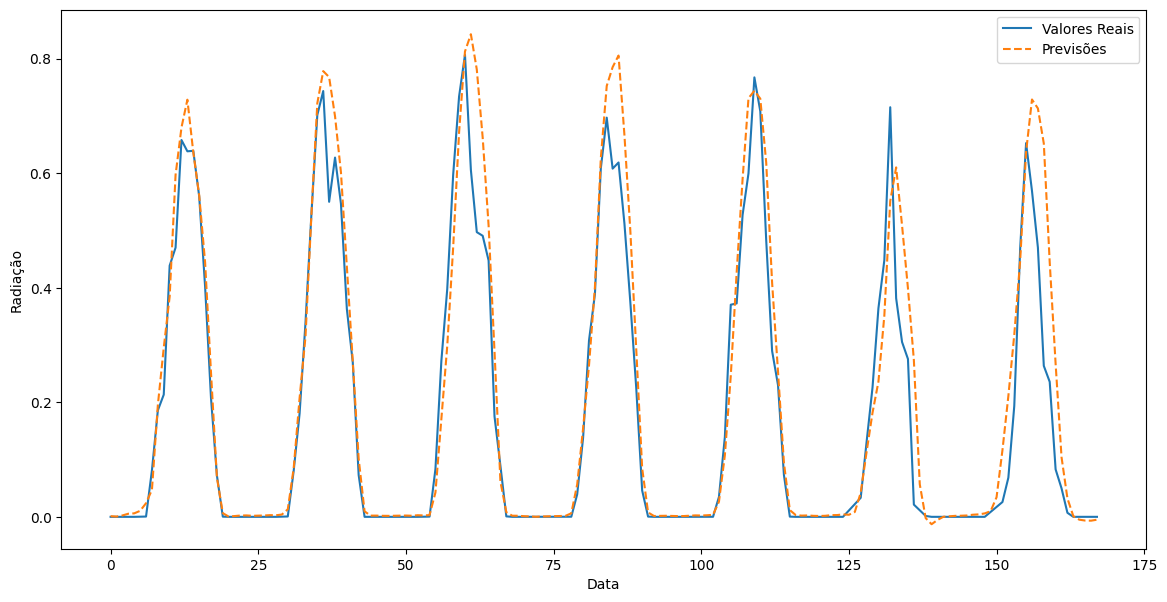

In [18]:
# Selecionando os últimos 7 * 24 valores para visualização
last_values = 7 * 24
y_lstm_last = y_test[-last_values:]
preds_lstm_last = y_pred_test[-last_values:]

# Plotando os últimos valores
plt.figure(figsize=(14, 7))

# Comparando a primeira coluna (ou ajusta conforme a quantidade de targets)
plt.plot(y_lstm_last, label='Valores Reais')
plt.plot(preds_lstm_last, label='Previsões', linestyle='--')

# plt.title('Predição vs Valores Reais (Últimos 7 dias)')
plt.xlabel('Data')
plt.ylabel('Radiação')
plt.legend()
plt.show()